This is used in the paper **Flexible cable routing framework for wind farm collection system optimization**.

In [1]:
from itertools import chain, pairwise, accumulate
import networkx as nx
import numpy as np

In [2]:
from interarray.svg import svgplot
from interarray.interarraylib import G_from_S, L_from_site
from interarray.mesh import make_planar_embedding

In [3]:
import vrplib

In [4]:
import urllib.request
import zipfile
import fnmatch
import os

In [21]:
import matplotlib.pyplot as plt
plt.style.use('jupyter_dark')

In [22]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

In [5]:
dir_instances = 'Vrp-Set-XML100/instances/'
dir_solutions = 'Vrp-Set-XML100/solutions/'

## Data download

Queiroga, E., Sadykov, R., Uchoa, E., & Vidal, T. (2021, November 24). 10,000 optimal CVRP solutions for testing machine learning based heuristics. AAAI-22 Workshop on Machine Learning for Operations Research (ML4OR). https://openreview.net/forum?id=yHiMXKN6nTl

In [ ]:
url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/Vrp-Set-XML100.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')

In [ ]:
instances = fnmatch.filter(zip_file_object.namelist(),
                           dir_instances + 'XML100_?11?_??.vrp')
solutions = fnmatch.filter(zip_file_object.namelist(),
                           dir_solutions + 'XML100_?11?_??.sol')
len(instances), len(solutions)

In [ ]:
for filename in instances + solutions:
    zip_file_object.extract(filename)

## If already downloaded skip to this cell

In [6]:
# now the lists do not include the full path
instances = os.listdir(dir_instances)
solutions = [instance.replace('/instances/', '/solutions/').replace('.vrp', '.sol')
             for instance in instances]
len(instances), len(solutions)

(480, 480)

## Definitions

In [7]:
def check_rogues(solution, A):
    rogues = []
    branches = ([n - 1 for n in branch] for branch in solution['routes'])
    for branch in branches:
        for edge in pairwise(branch):
            if edge not in A.edges:
                rogues.append(edge)
    return rogues

In [8]:
def S_from_vrplib(solution, Sʹ):
    '''
    Beware: assumes a single depot!
    '''
    # create a topology graph S from the solution
    S = nx.Graph(
        T=Sʹ.graph['T'], R=Sʹ.graph['R'],
        capacity=Sʹ.graph['capacity'],
        has_loads=True,
        objective=solution['cost'],
        creator='vrplib',
    )

    branches = ([n - 1 for n in branch] for branch in solution['routes'])
    for subtree_id, branch in enumerate(branches):
        loads = range(len(branch), 0, -1)
        S.add_nodes_from(((n, {'load': load})
                          for n, load in zip(branch, loads)),
                         subtree=subtree_id)
        branch_roll = [-1] + branch[:-1]
        reverses = tuple(u < v for u, v in zip(branch, branch_roll))
        edgeD = ({'load': load, 'reverse': reverse}
                 for load, reverse in zip(loads, reverses))
        S.add_edges_from(zip(branch_roll, branch, edgeD))
    root_load = sum(S.nodes[n]['load'] for n in S.neighbors(-1))
    S.nodes[-1]['load'] = root_load
    return S

In [9]:
def L_from_vrplib(instance):
    R = len(instance['depot'])
    T = instance['dimension'] - R
    # make sure depots are numbered 0..M-1
    assert all(depot == i for i, depot in enumerate(instance['depot']))
    L = L_from_site(
        B=4, border=list(range(T, T + 4)),
        R=R, T=T, name=instance['name'], capacity=instance['capacity'],
        VertexC=np.vstack((instance['node_coord'][R:],
                           [[0,0], [1000, 0], [1000, 1000], [0, 1000]],
                           instance['node_coord'][:R])),
    )
    return L

## Examine XML100 \_11\_

(i.e. random client positions, 1-demand)

In [10]:
inst_id = '2115_07'
instance = vrplib.read_instance(dir_instances + f'XML100_{inst_id}.vrp')
solution = vrplib.read_solution(dir_solutions + f'XML100_{inst_id}.sol')

In [11]:
instance.keys()

dict_keys(['name', 'comment', 'type', 'dimension', 'edge_weight_type', 'capacity', 'node_coord', 'demand', 'depot', 'edge_weight'])

In [12]:
solution.keys()

dict_keys(['routes', 'cost'])

In [13]:
L = L_from_vrplib(instance)

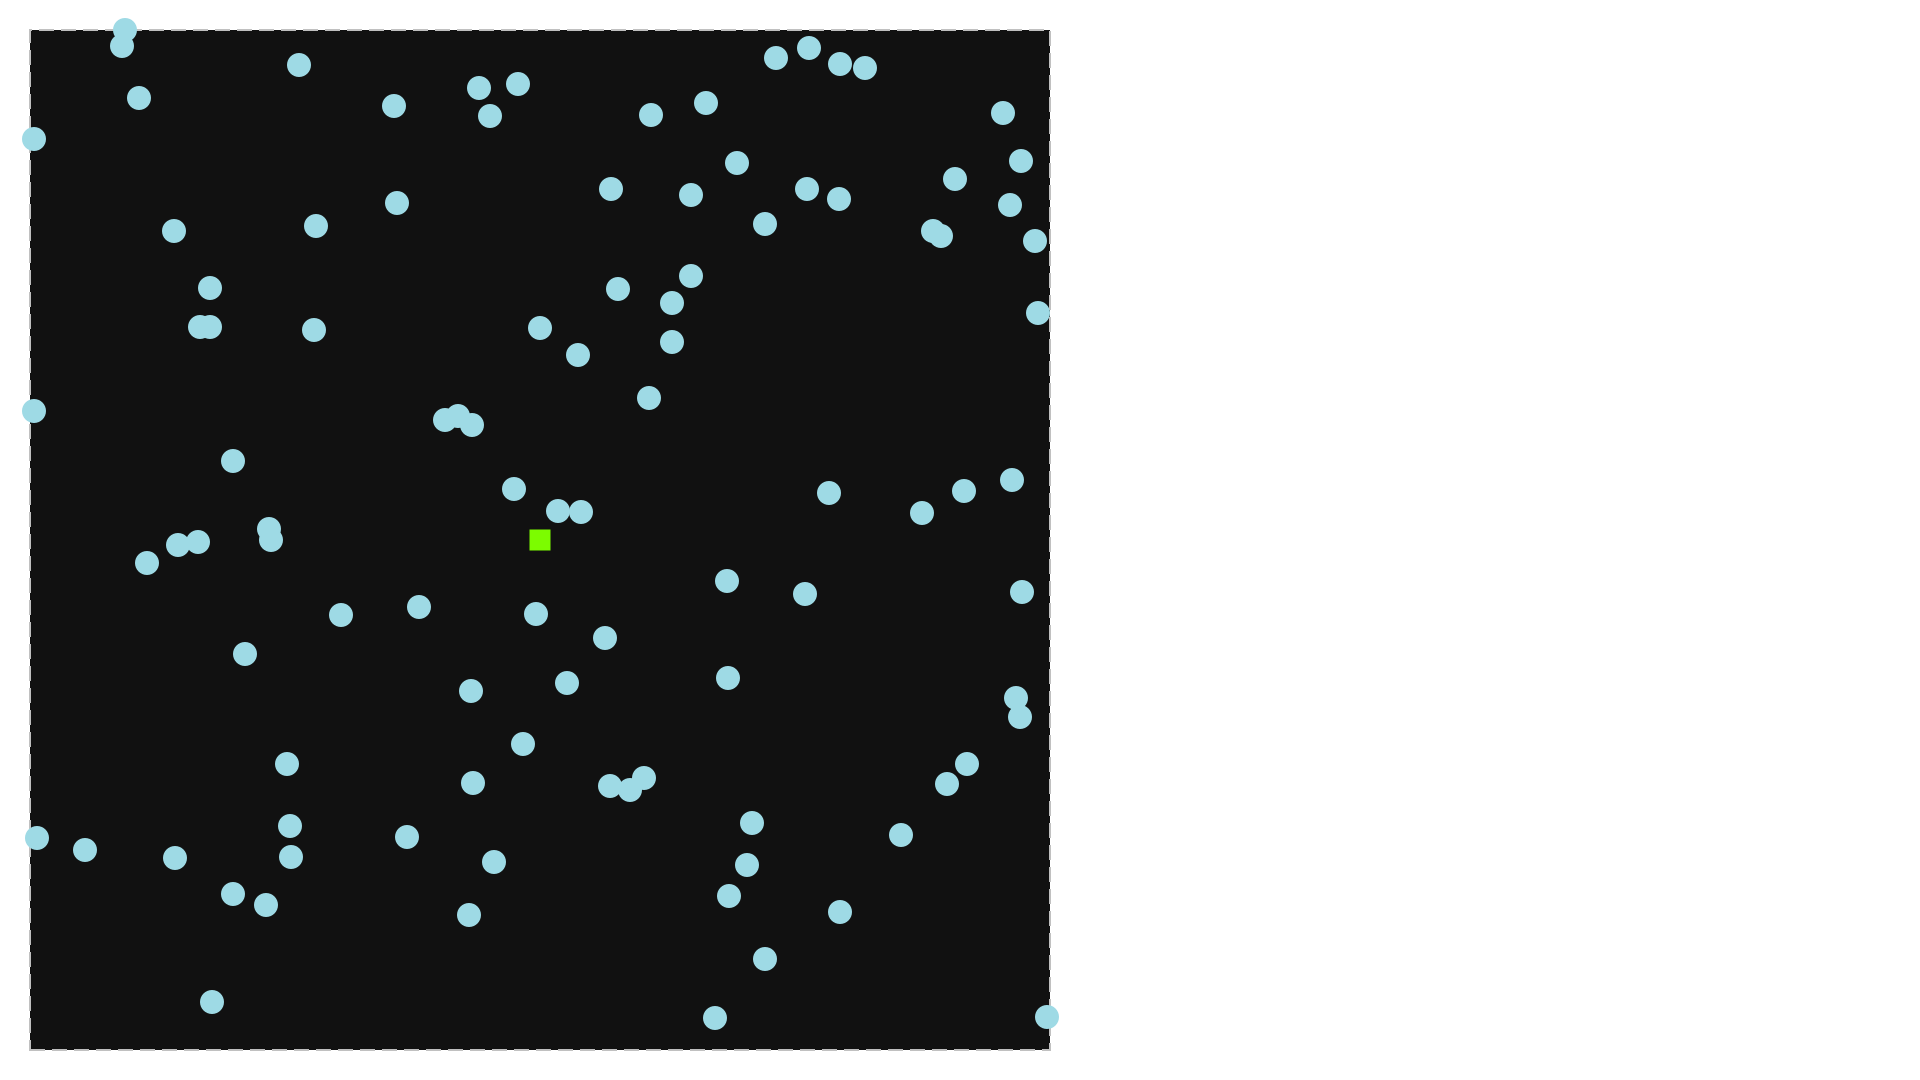

In [14]:
svgplot(L)

In [15]:
P, A = make_planar_embedding(L)

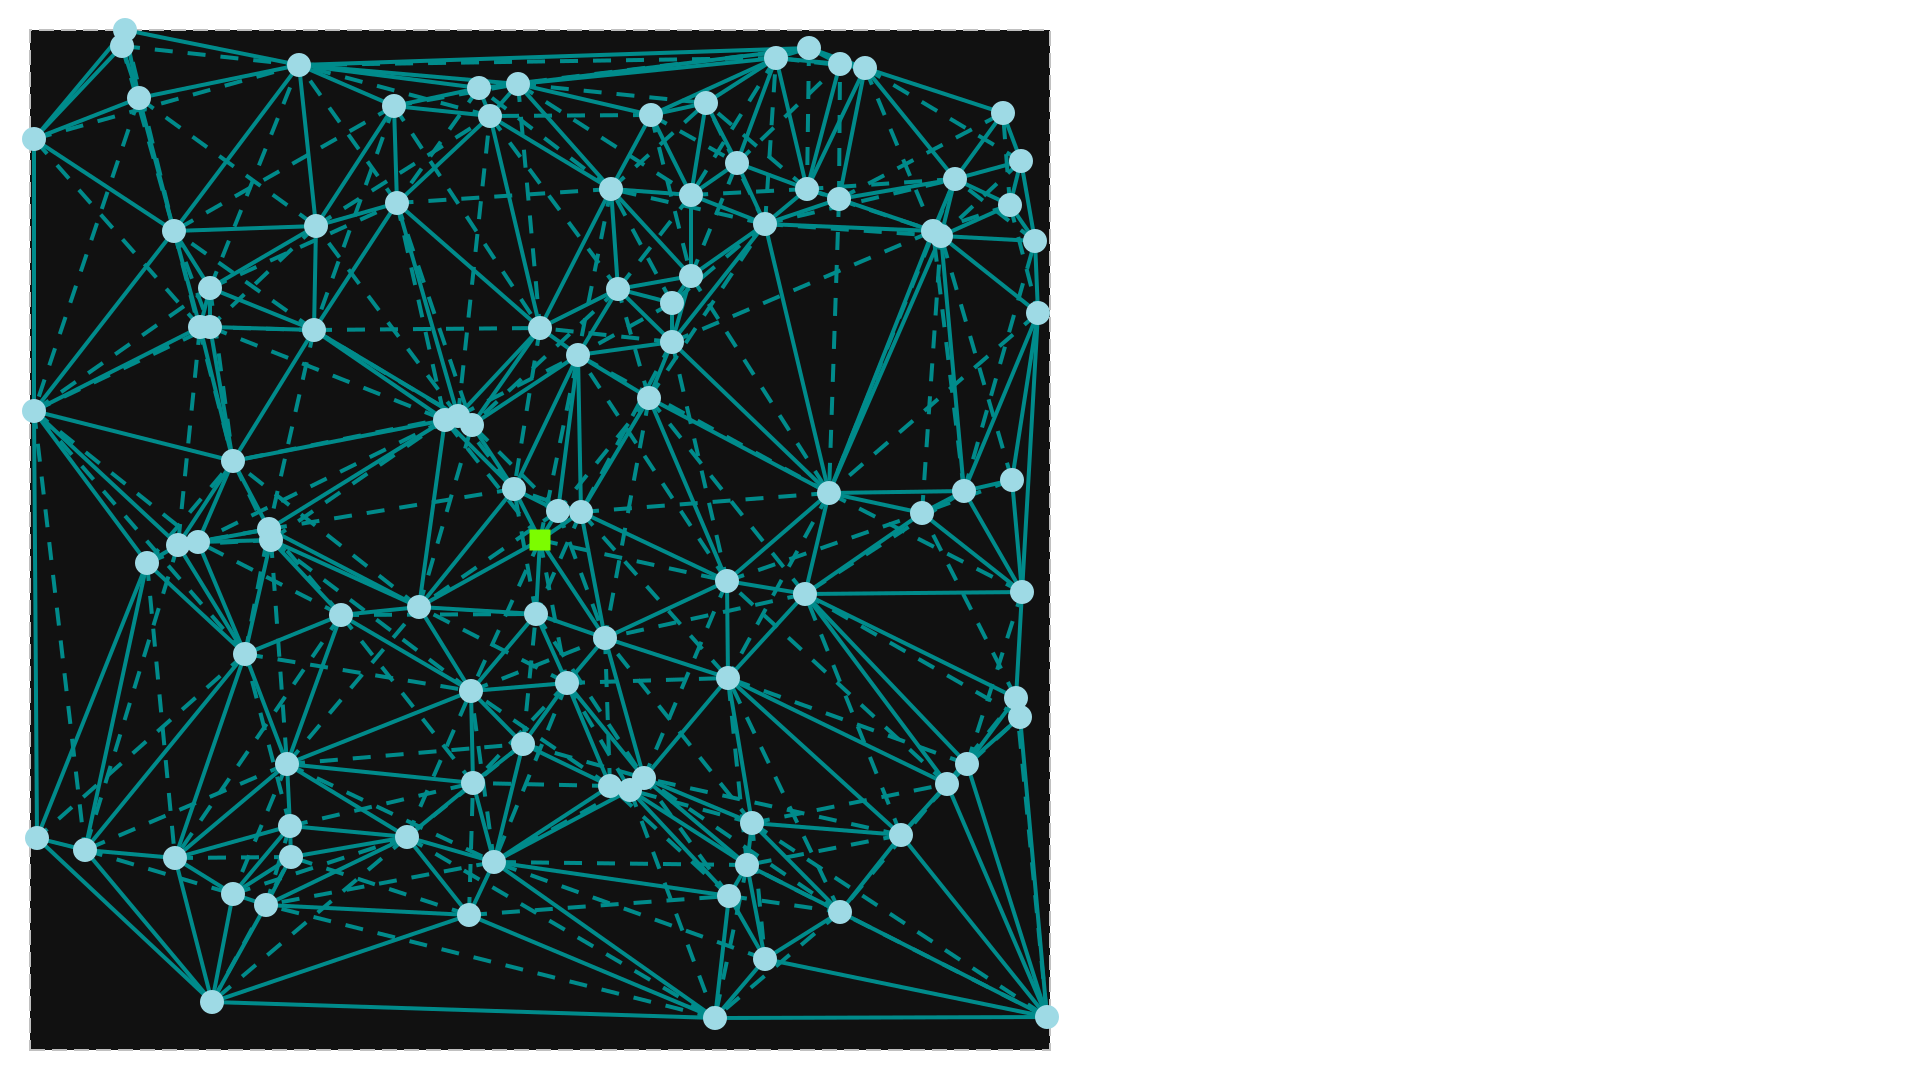

In [16]:
svgplot(A)

In [17]:
S = S_from_vrplib(solution, L)

In [18]:
G = G_from_S(S, A)

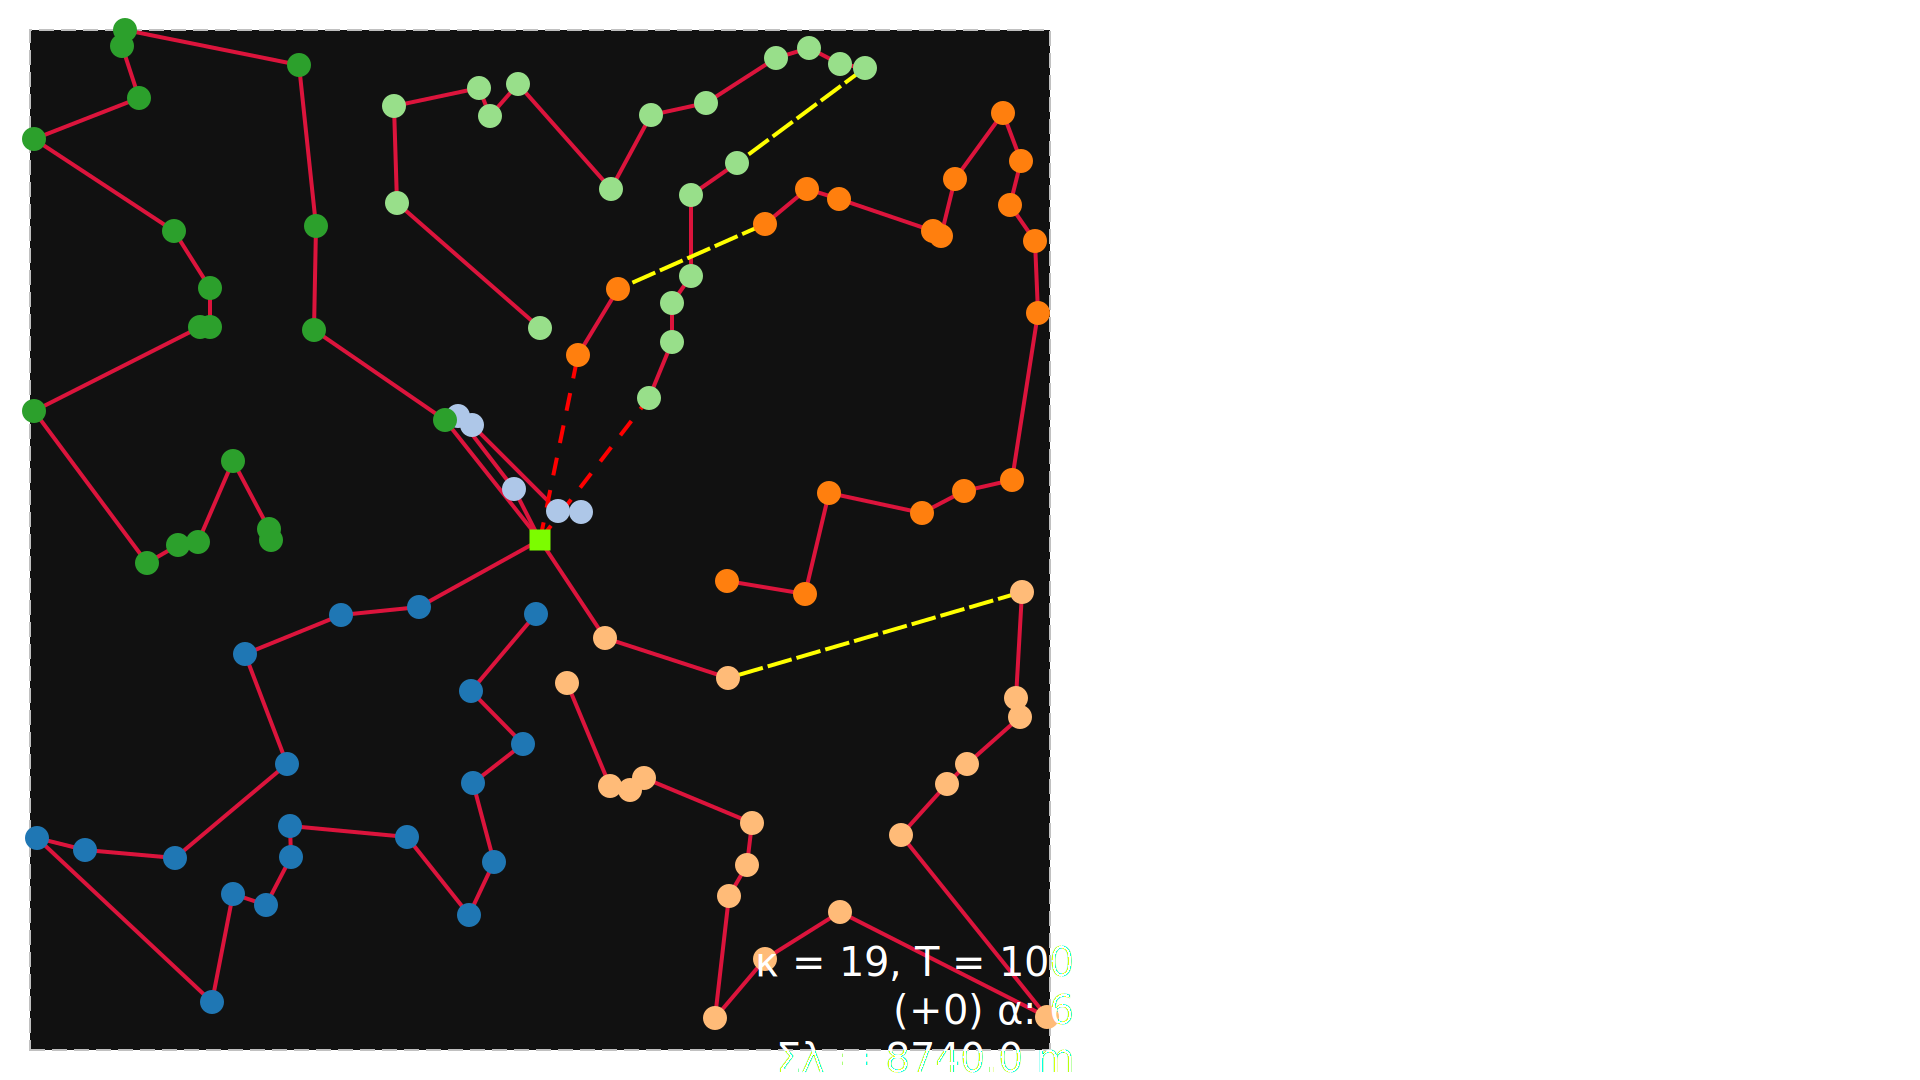

In [19]:
svgplot(G)

## Get Statistics!

In [20]:
num_instances = 0
num_total_edges = 0
num_total_rogues = 0
edge_counts = []
problems = []
for solfile in solutions:
    num_instances += 1
    vrpfile = solfile.replace('.sol', '.vrp')
    instance = vrplib.read_instance(dir_instances + vrpfile)
    solution = vrplib.read_solution(dir_solutions + solfile)
    L = L_from_vrplib(instance)
    P, A = make_planar_embedding(L)
    S = S_from_vrplib(solution, L)
    num_gates = S.degree[-1]
    # num_edges = T.number_of_edges() - num_gates
    # num_total_edges += num_edges
    num_edges = S.number_of_edges()
    num_total_edges += num_edges
    edge_counts.append(num_edges)
    rogues = check_rogues(solution, A)
    if rogues:
        # print(rogues)
        num_total_rogues += len(rogues)
        G = G_from_S(S, A)
        problems.append((solfile.split('/')[-1], rogues, svgplot(G)))
        print(f'ROGUES ({len(rogues)}):', solfile)
    else:
        print('CLEAN:', solfile)

ROGUES (4): XML100_1111_01.sol
CLEAN: XML100_1111_02.sol
ROGUES (2): XML100_1111_03.sol
ROGUES (1): XML100_1111_04.sol
ROGUES (1): XML100_1111_05.sol
ROGUES (2): XML100_1111_06.sol
ROGUES (1): XML100_1111_07.sol
CLEAN: XML100_1111_08.sol
ROGUES (2): XML100_1111_09.sol
CLEAN: XML100_1111_10.sol
ROGUES (2): XML100_1111_11.sol
ROGUES (1): XML100_1111_12.sol
CLEAN: XML100_1111_13.sol
CLEAN: XML100_1111_14.sol
CLEAN: XML100_1111_15.sol
CLEAN: XML100_1111_16.sol
ROGUES (1): XML100_1111_17.sol
ROGUES (2): XML100_1111_18.sol
ROGUES (1): XML100_1111_19.sol
CLEAN: XML100_1111_20.sol
CLEAN: XML100_1111_21.sol
CLEAN: XML100_1111_22.sol
ROGUES (2): XML100_1111_23.sol
CLEAN: XML100_1111_24.sol
CLEAN: XML100_1111_25.sol
CLEAN: XML100_1111_26.sol
CLEAN: XML100_1111_27.sol
ROGUES (2): XML100_1112_01.sol
ROGUES (3): XML100_1112_02.sol
ROGUES (2): XML100_1112_03.sol
CLEAN: XML100_1112_04.sol
ROGUES (2): XML100_1112_05.sol
ROGUES (2): XML100_1112_06.sol
ROGUES (4): XML100_1112_07.sol
ROGUES (1): XML100_11

In [23]:
rogue_counts = np.array([len(rogues) for _, rogues, _ in problems])
num_rogues_range = range(0, max(rogue_counts) + 1)
count_per_num_rogues = [sum(rogue_counts == num_rogues) for num_rogues in num_rogues_range]
count_per_num_rogues[0] = num_instances - len(problems)

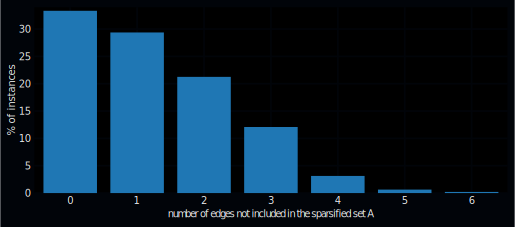

In [24]:
plt.bar(num_rogues_range, 100*np.array(count_per_num_rogues)/num_instances);
plt.xlabel('number of edges not included in the sparsified set $A$')
plt.ylabel('% of instances');

In [25]:
bench_pct_per_num_rogues = 100*np.array(count_per_num_rogues)/num_instances

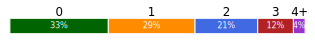

In [26]:
with plt.style.context('pub_paperfarm'):
    fig, ax = plt.subplots(figsize=(4.2, 0.4))
    values = list(chain(bench_pct_per_num_rogues[:4],
                  (sum(bench_pct_per_num_rogues[4:]),)))
    tags = '0', '1', '2', '3', '4+'
    colors = 'darkgreen', 'darkorange', 'royalblue', 'firebrick', 'darkorchid'
    limits = list(accumulate(values, initial=0))
    centers = [(a + b)/2 for a, b in pairwise(limits)]
    ax.barh(0, values, left=limits[:-1], color=colors, edgecolor='white')
    value_tags = [ax.text(x, 0, f'{v:.0f}%',
                          color='white', fontsize='small',
                          verticalalignment='center',
                          horizontalalignment='center') for v, x in zip(values, centers)]
    label_tags = [ax.text(x, 0.7, s,
                          fontsize='large',
                          verticalalignment='center',
                          horizontalalignment='center') for s, x in zip(tags, centers)]
    ax.axis(False)
    ax.set_xlim(0, 100)
    ax.figure.savefig('XML100_480_edges_not_in_A.pdf')

In [27]:
# this counts feeders in num_total_edges
num_total_rogues/num_total_edges

0.0125

## Check the rogues >= 4 offenders

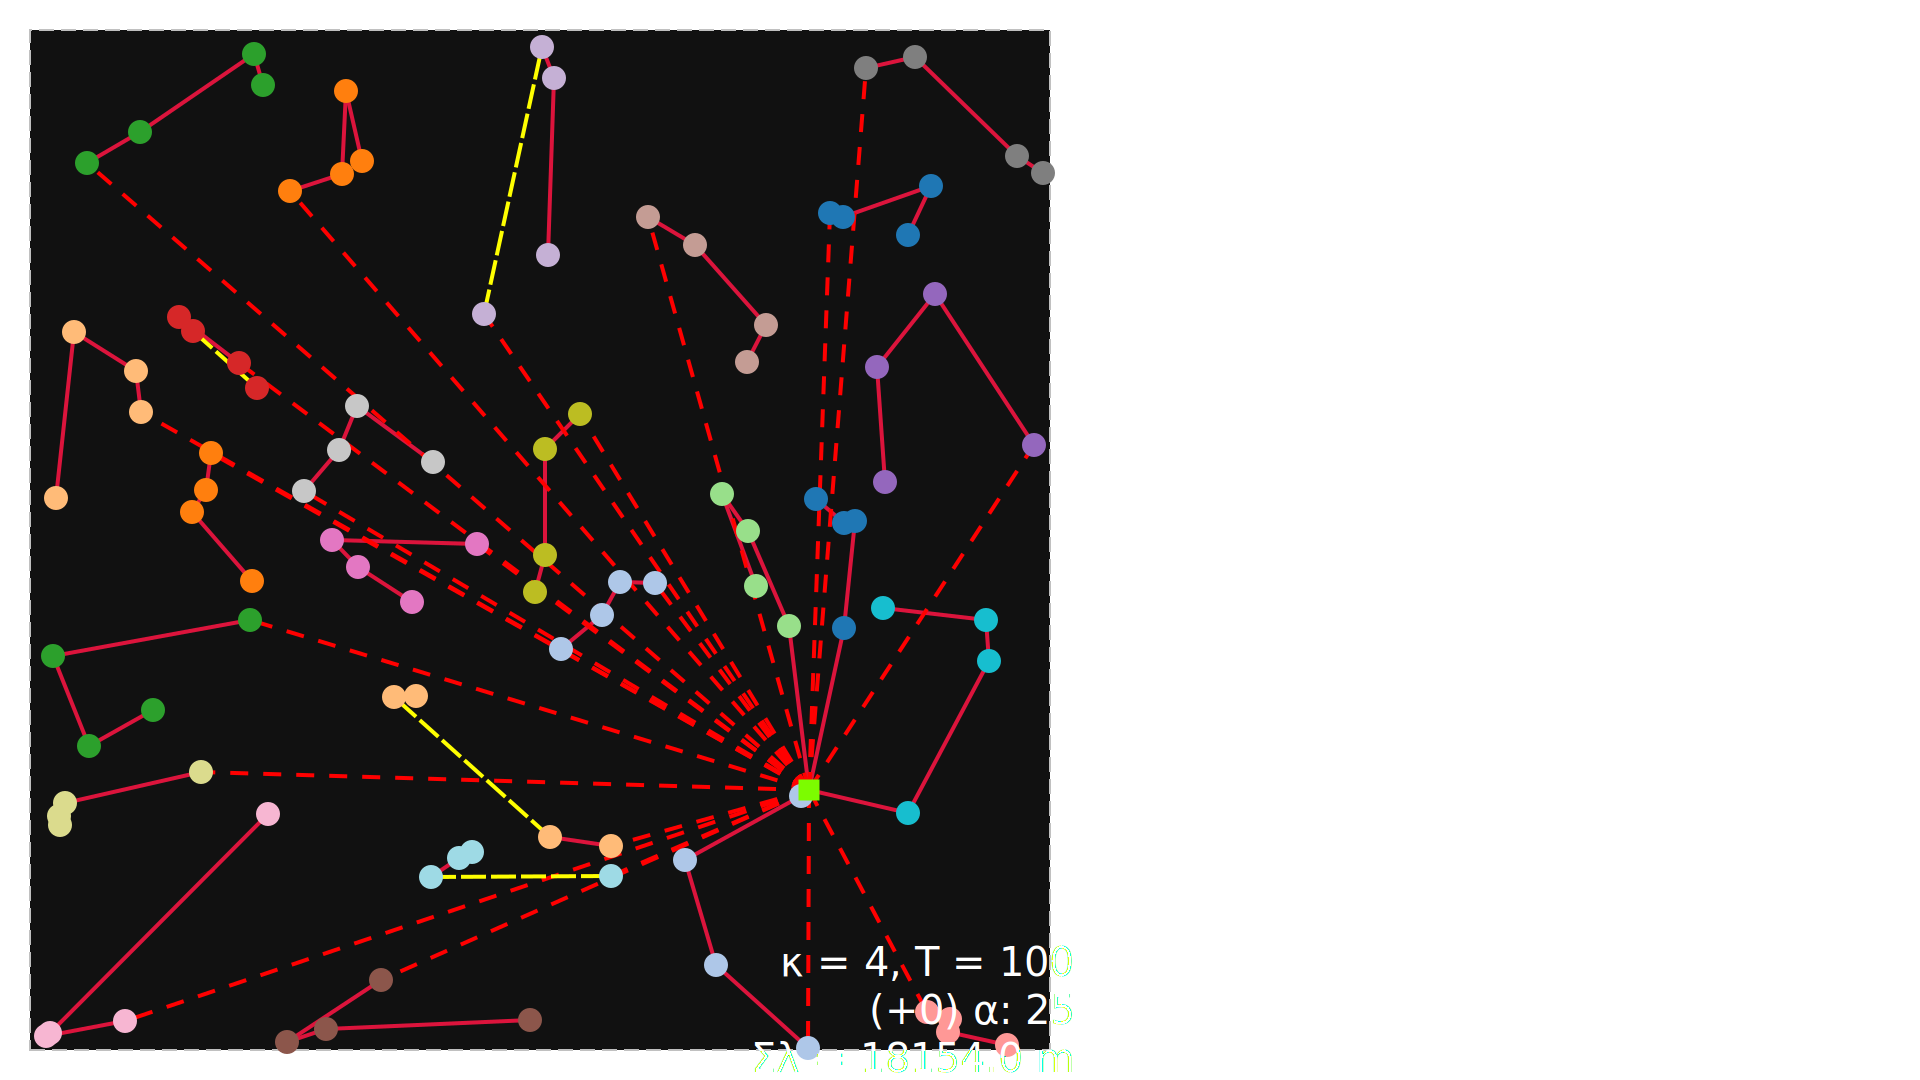

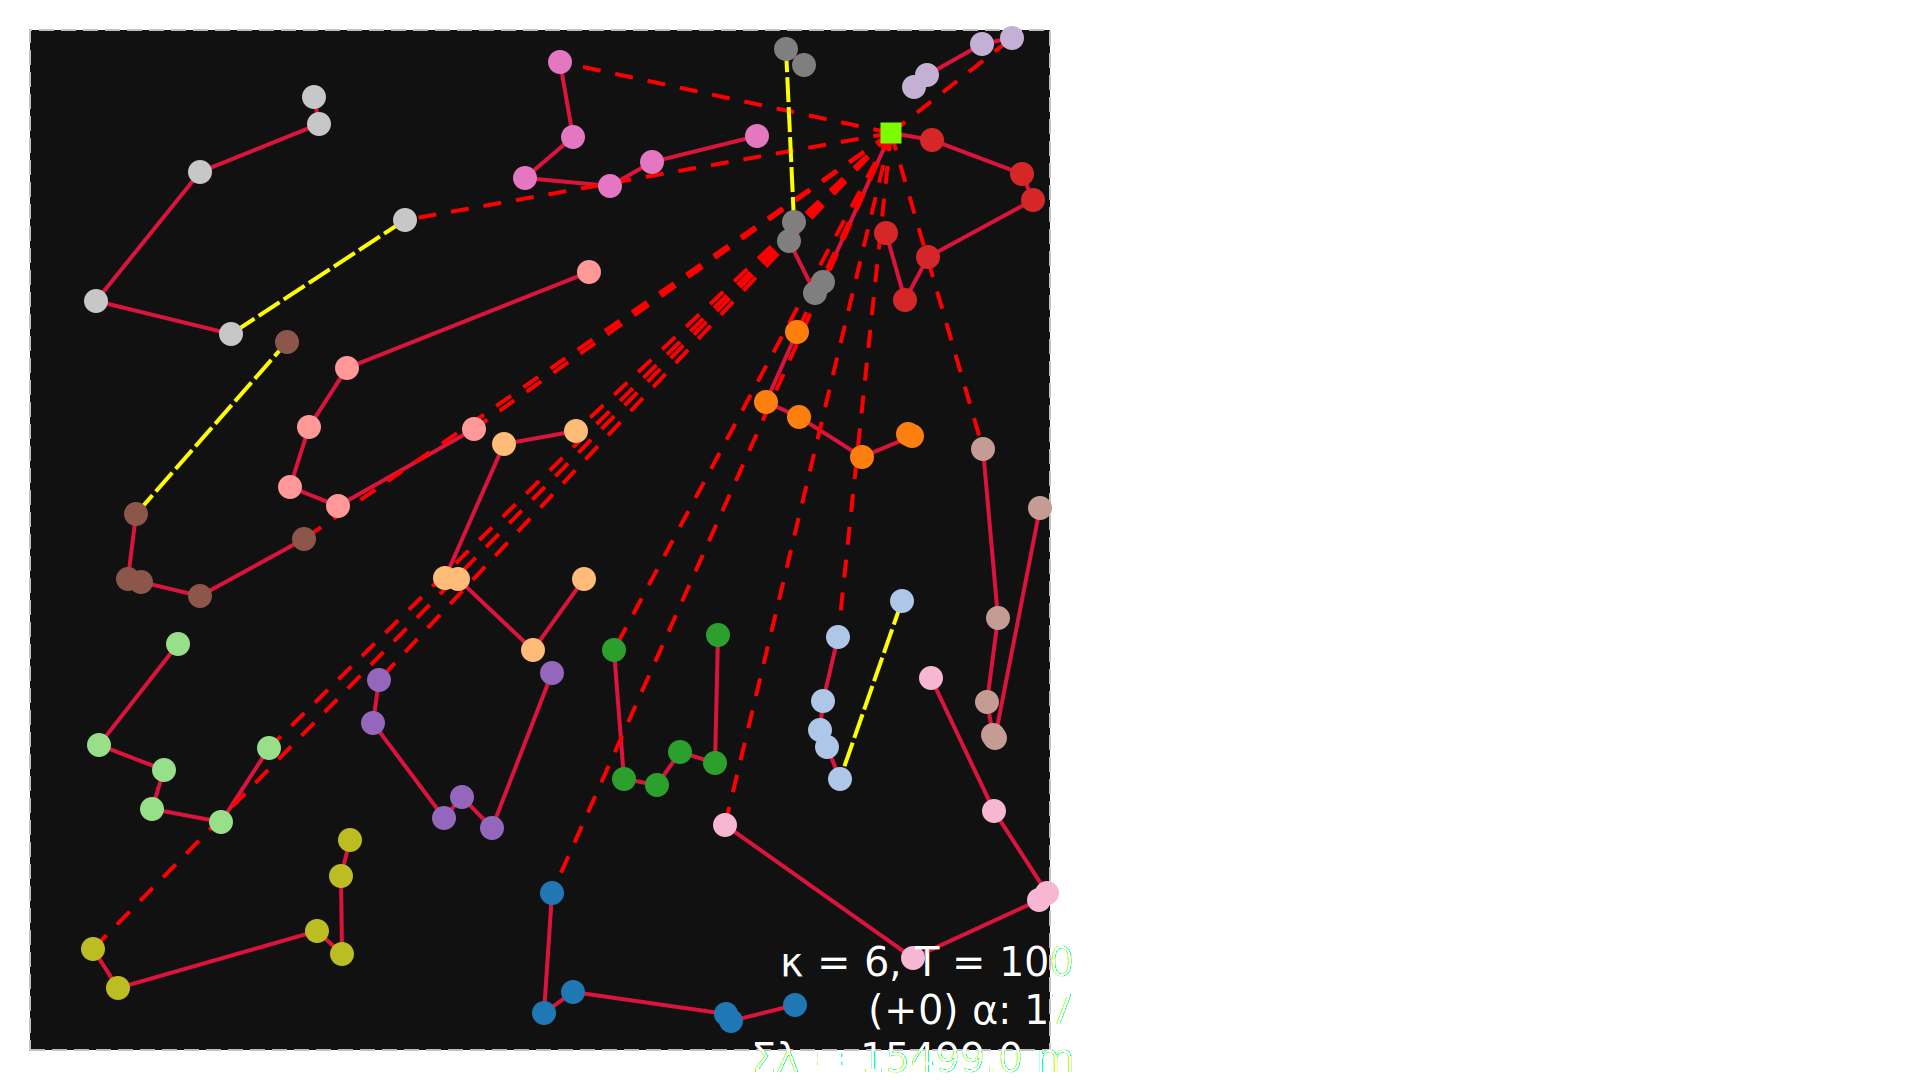

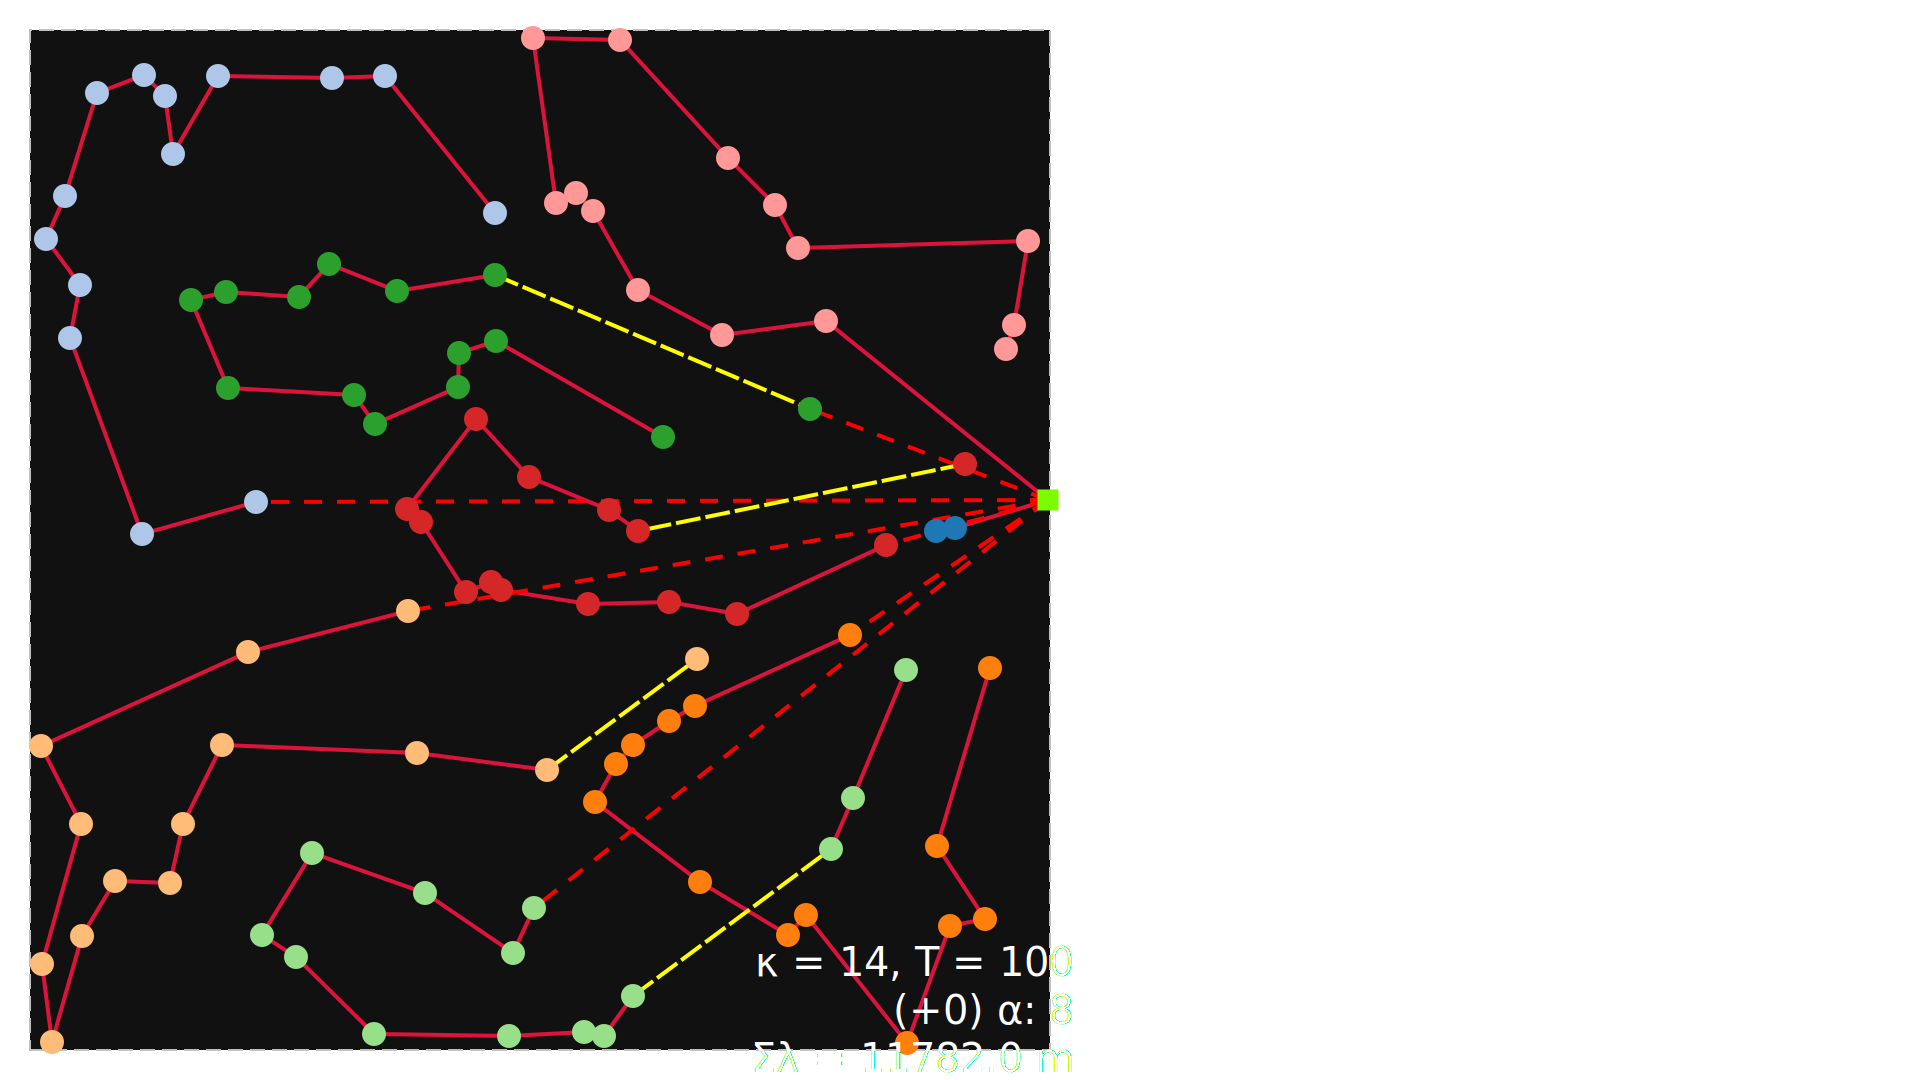

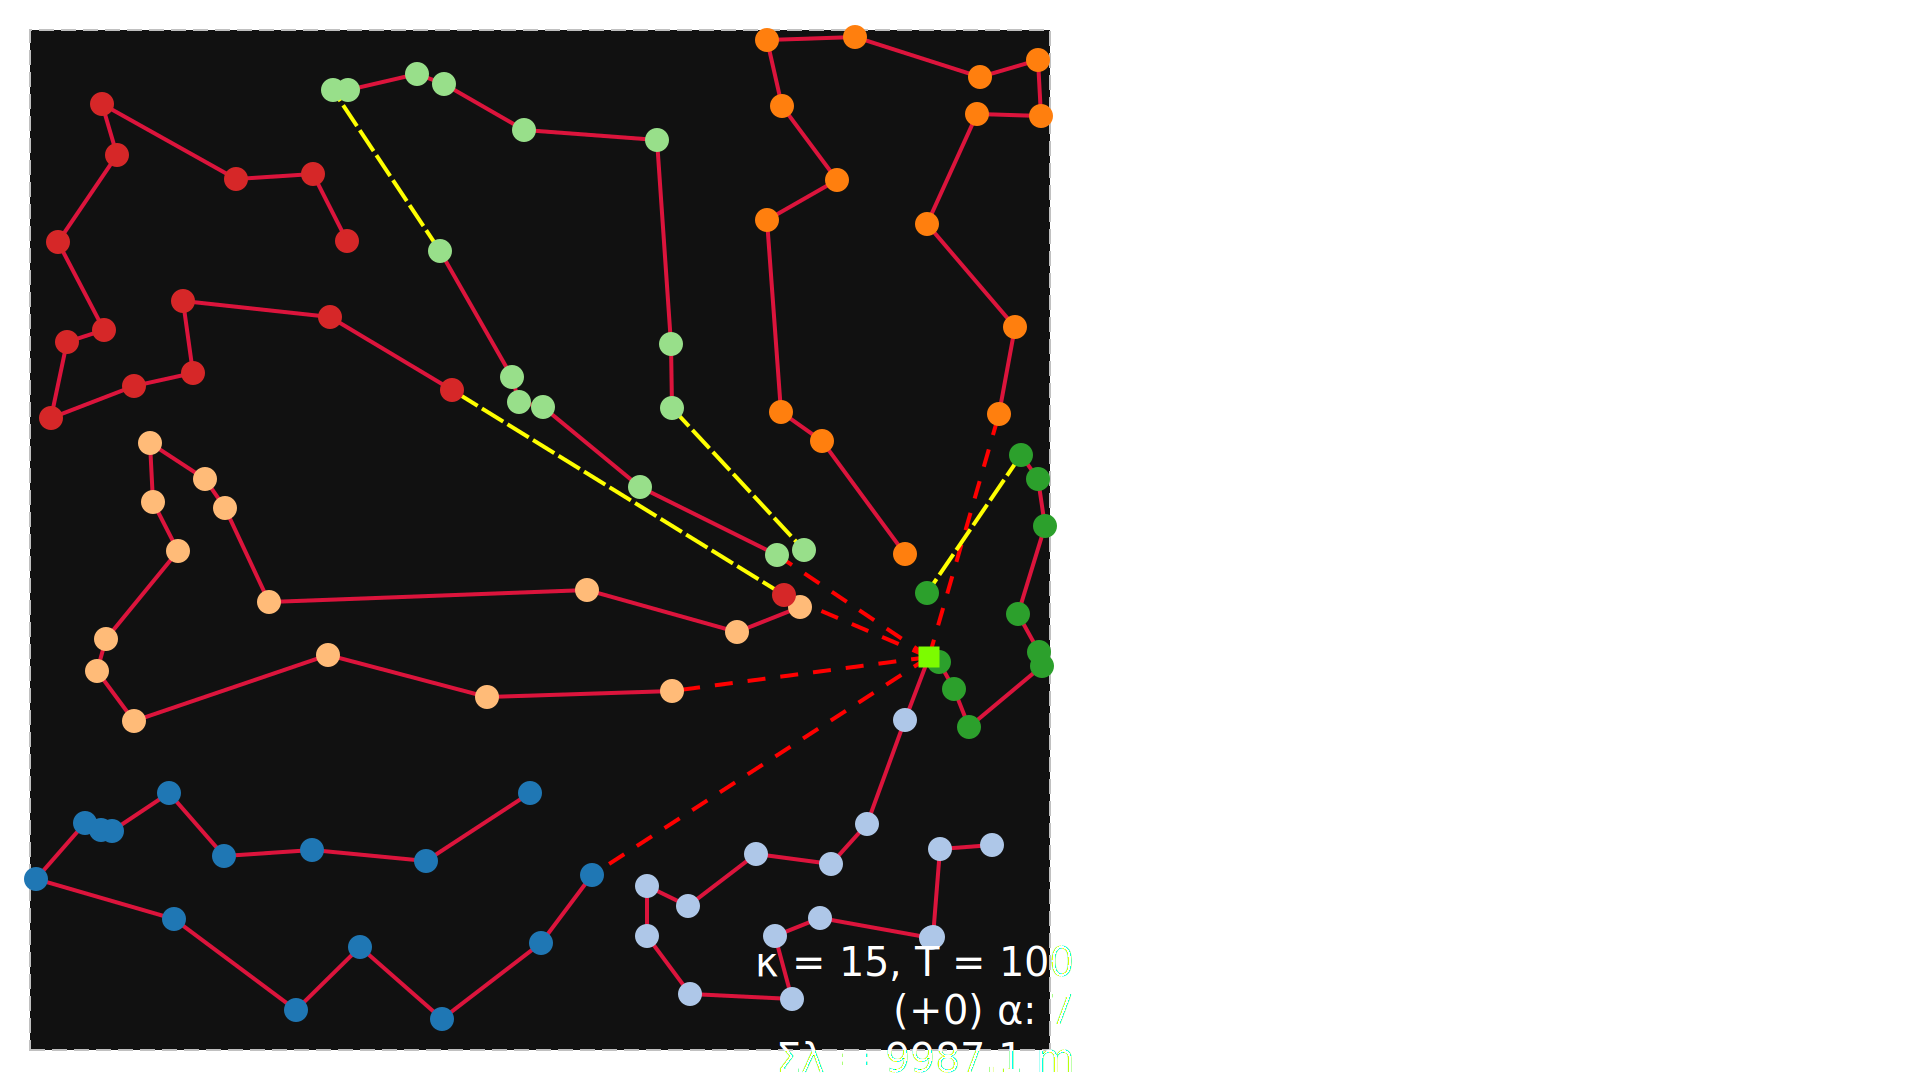

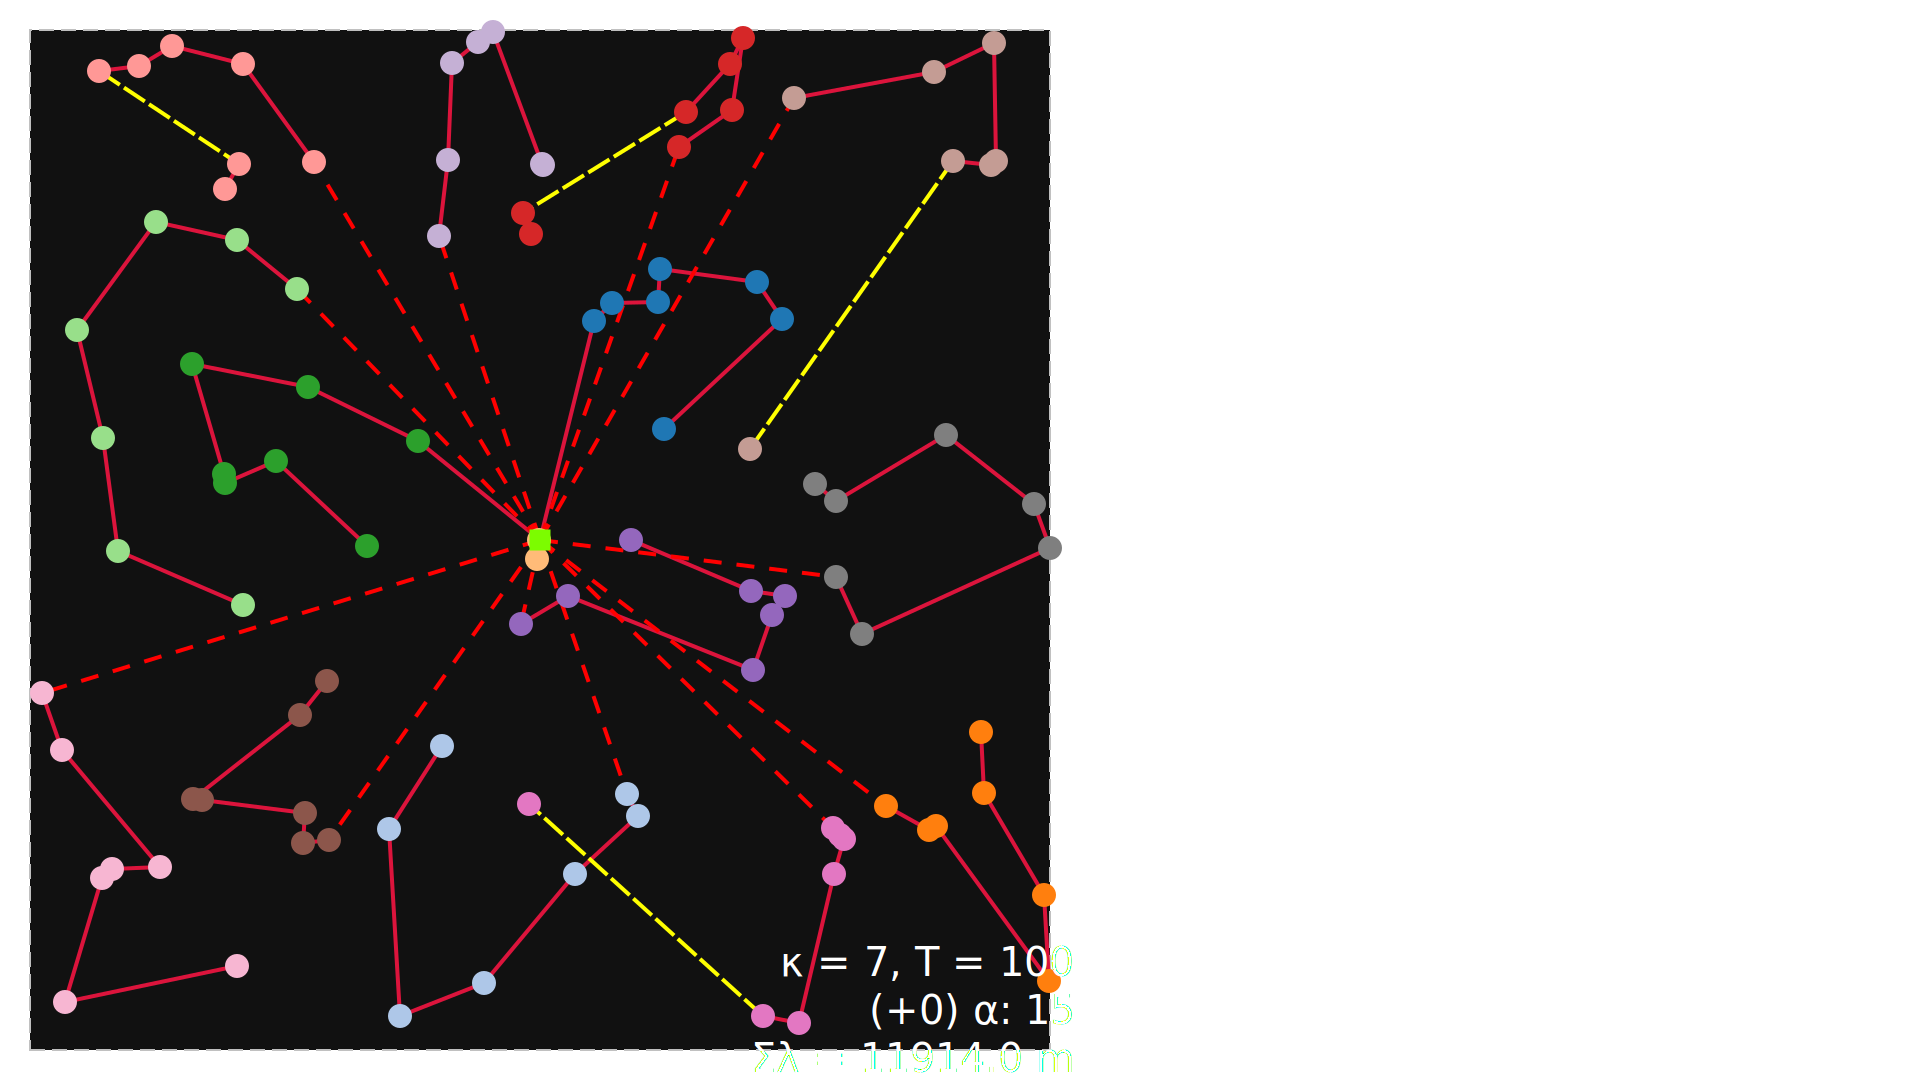

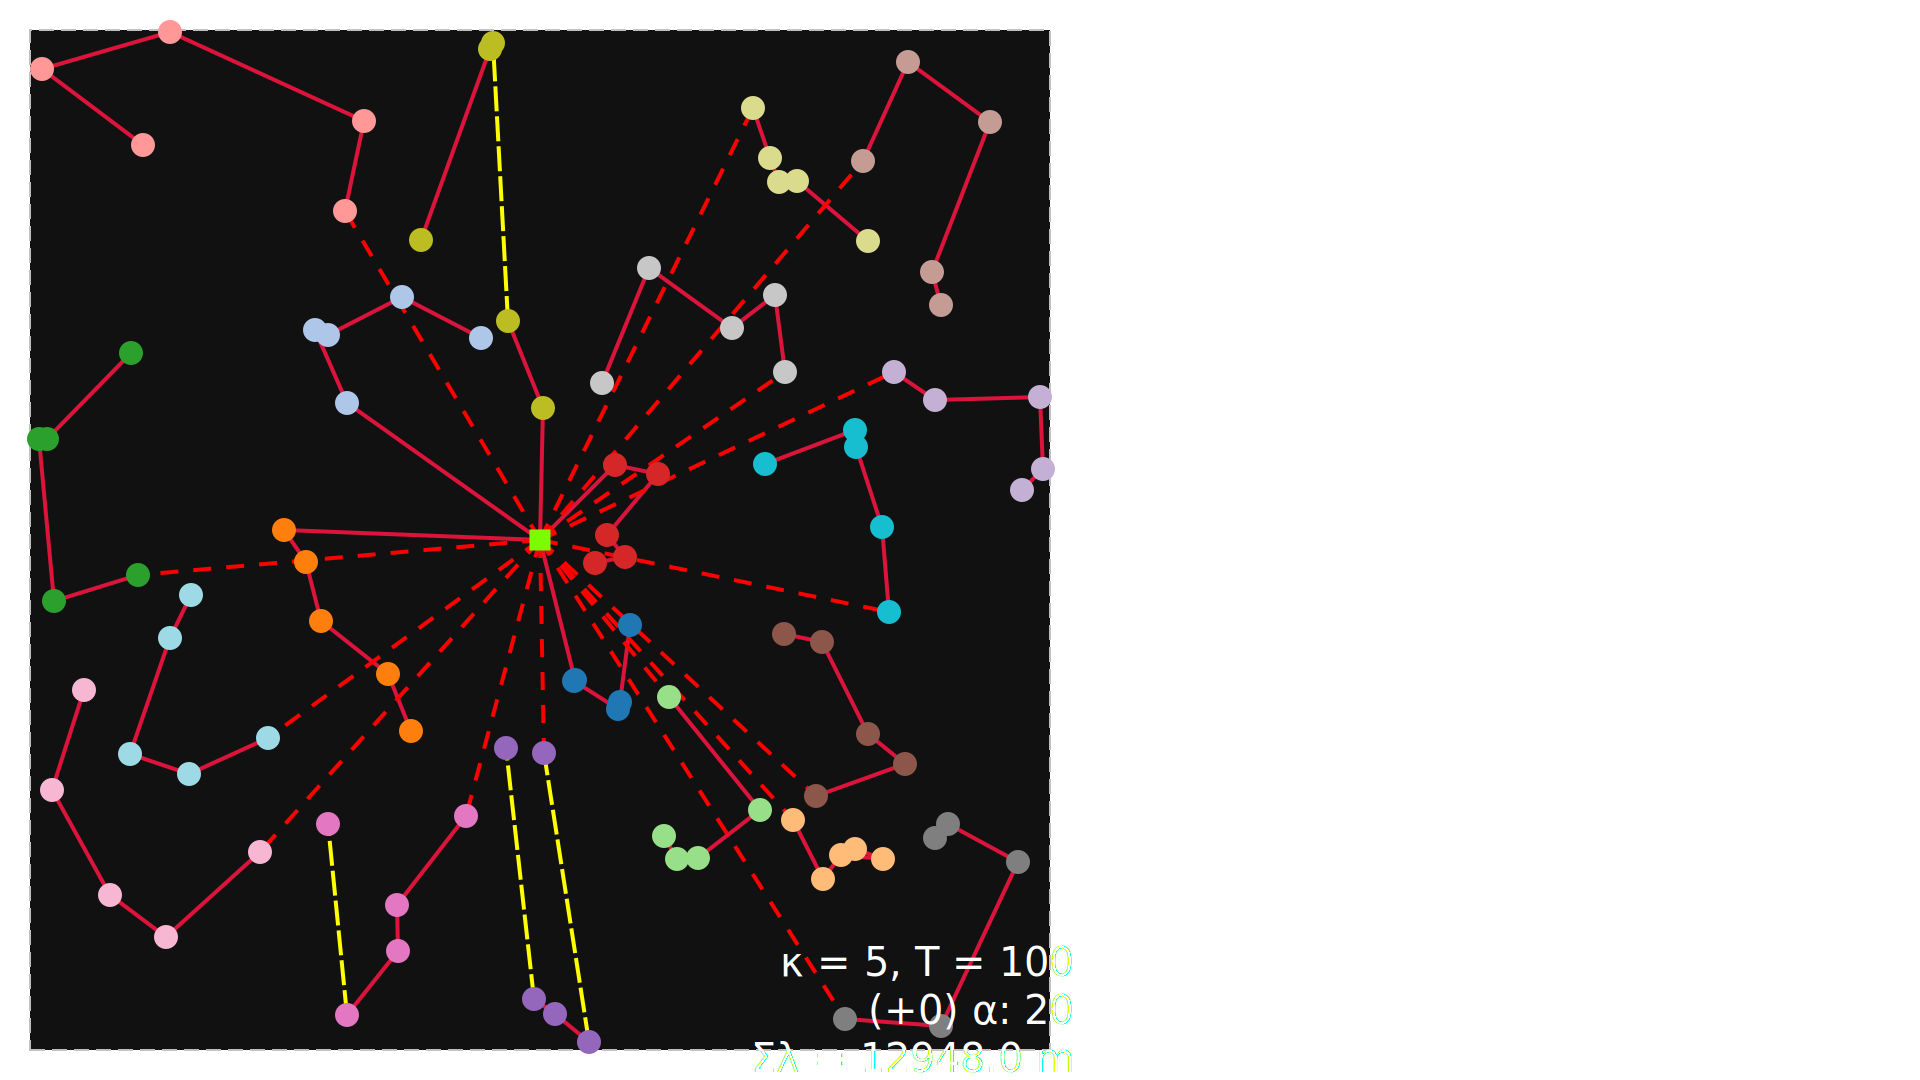

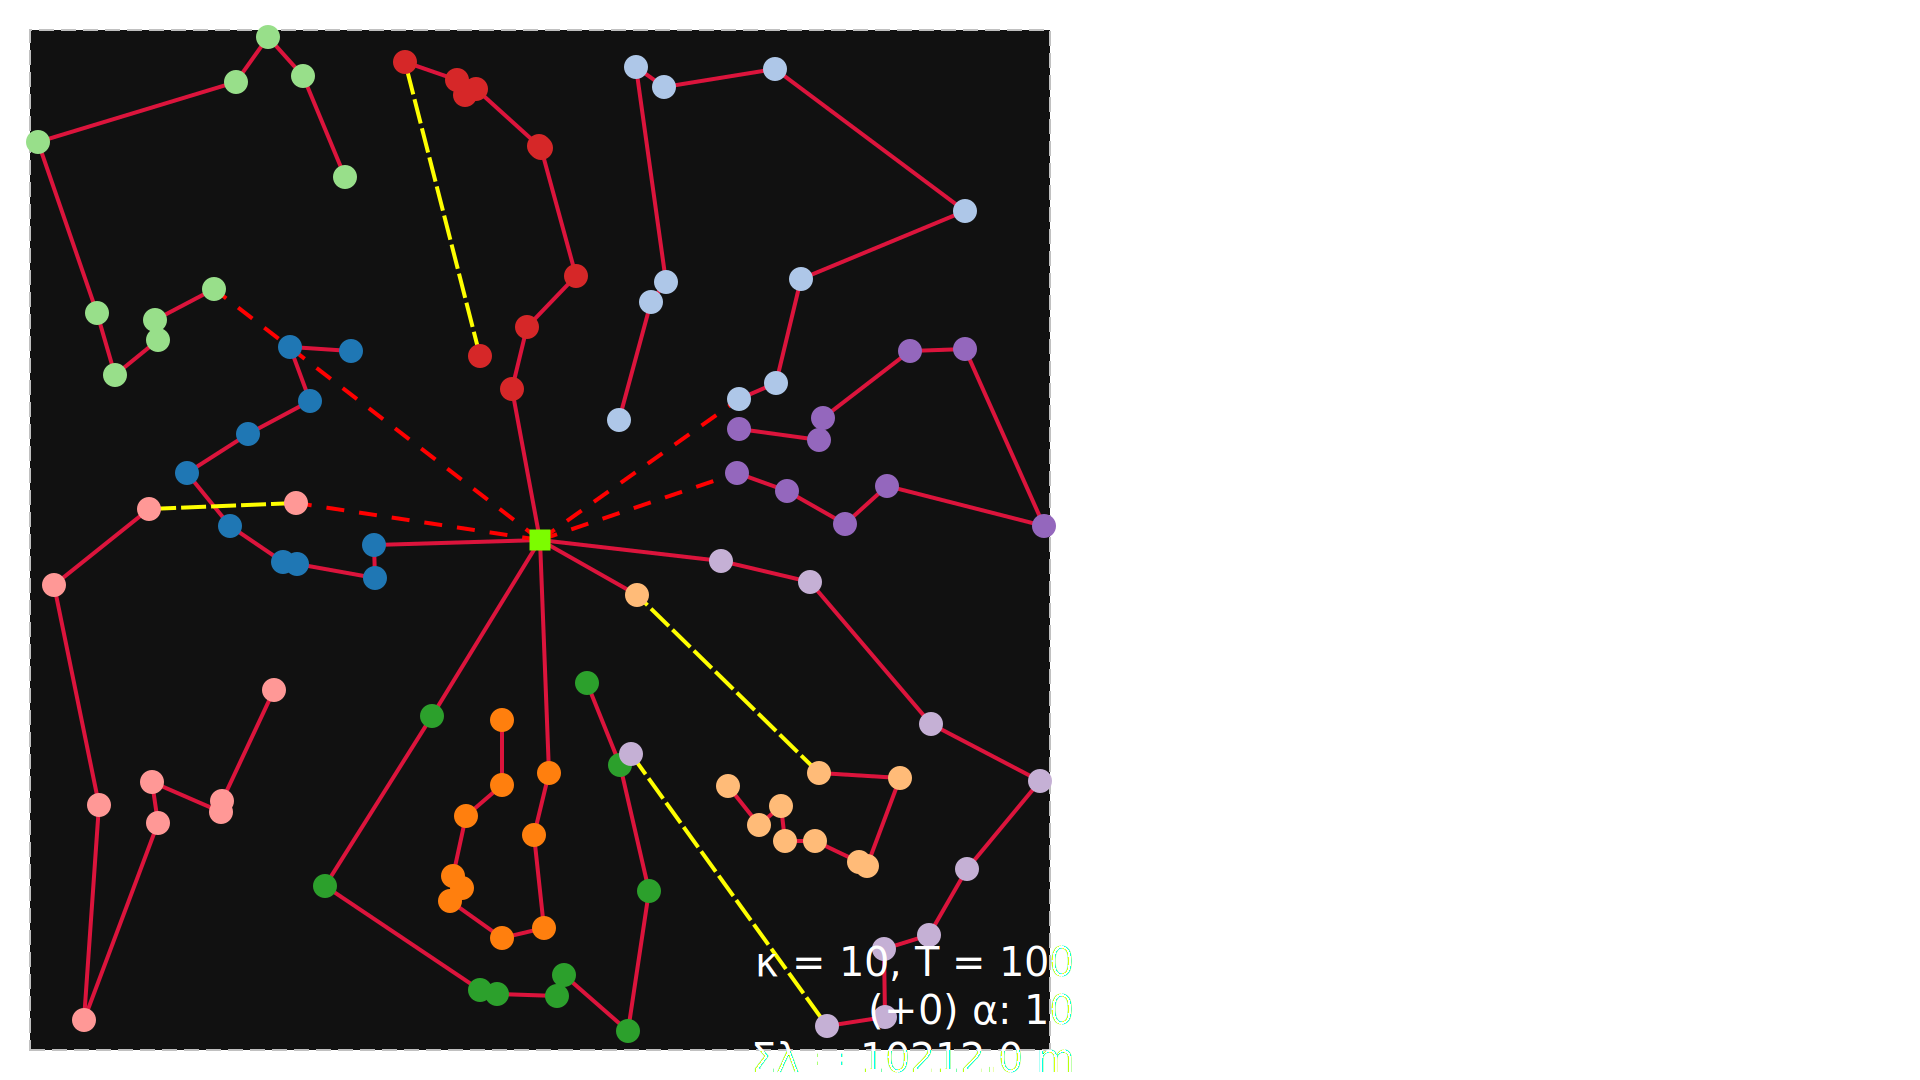

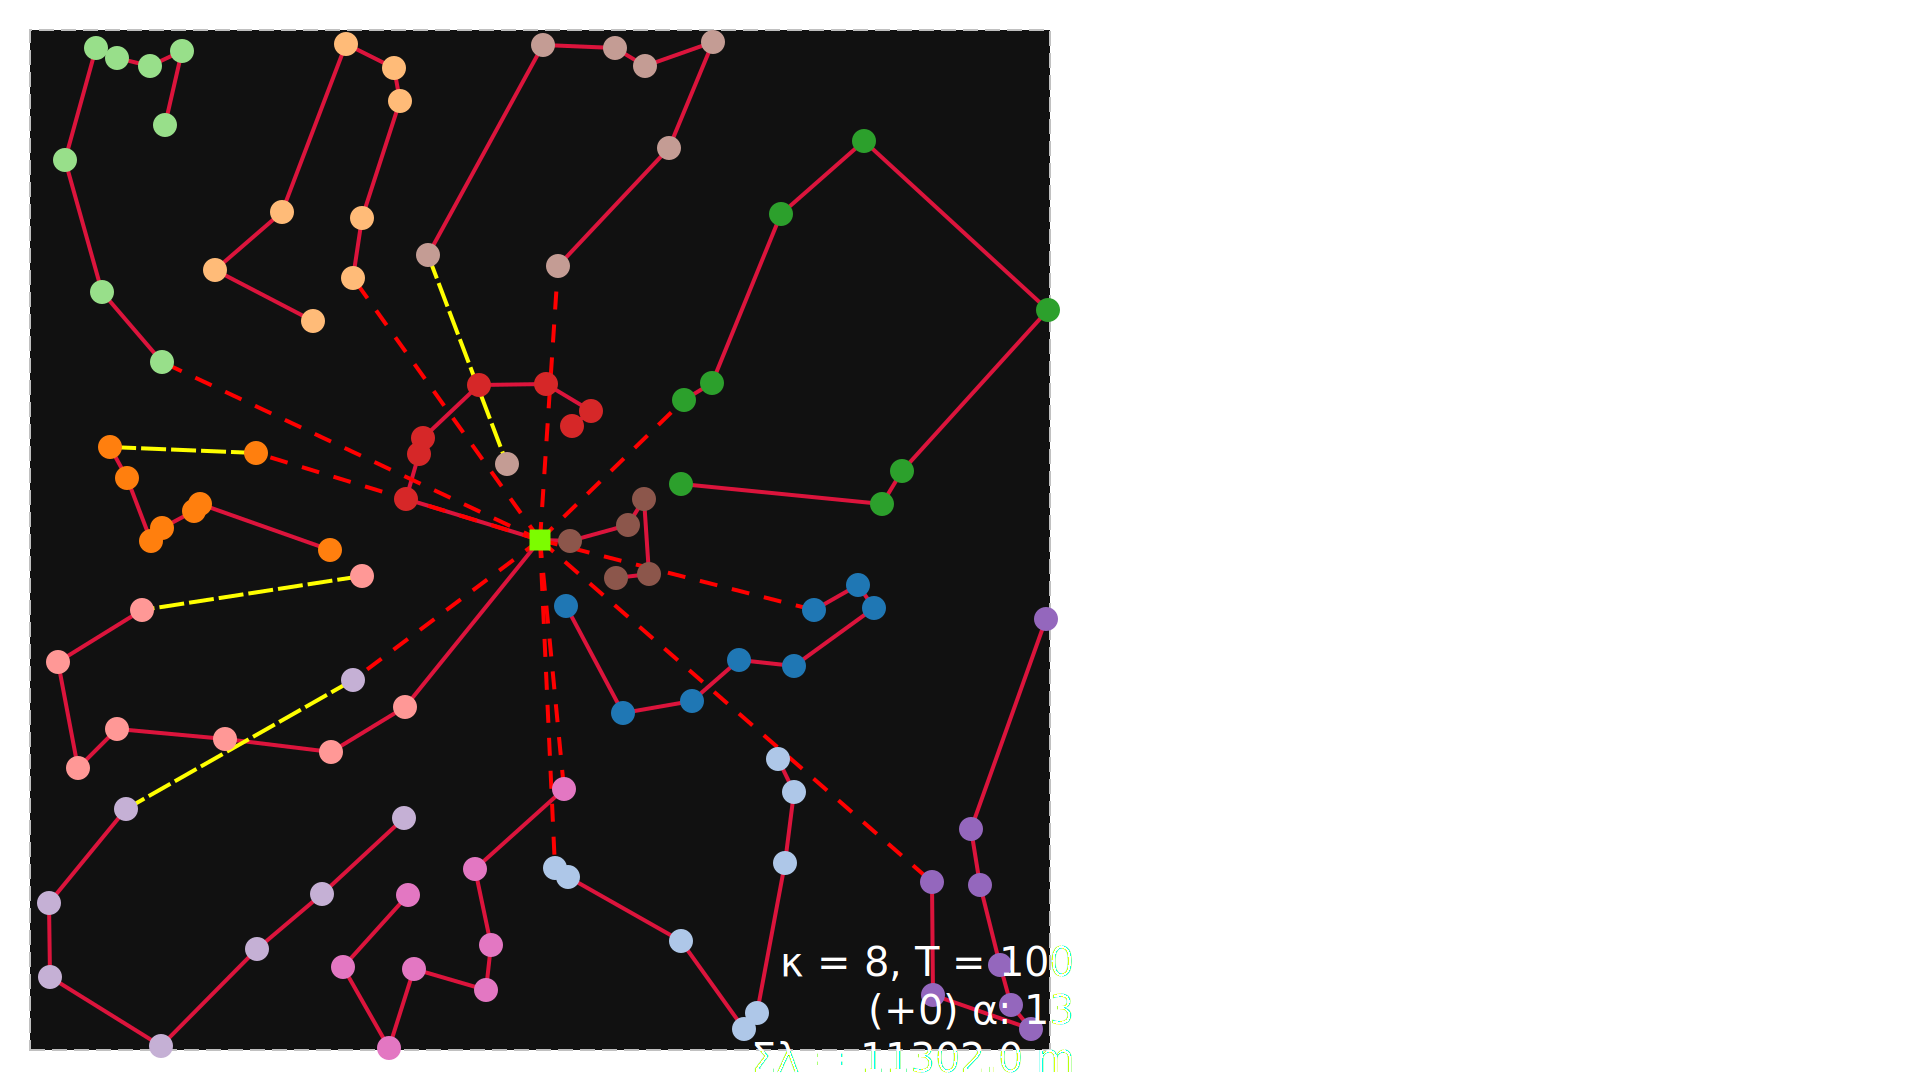

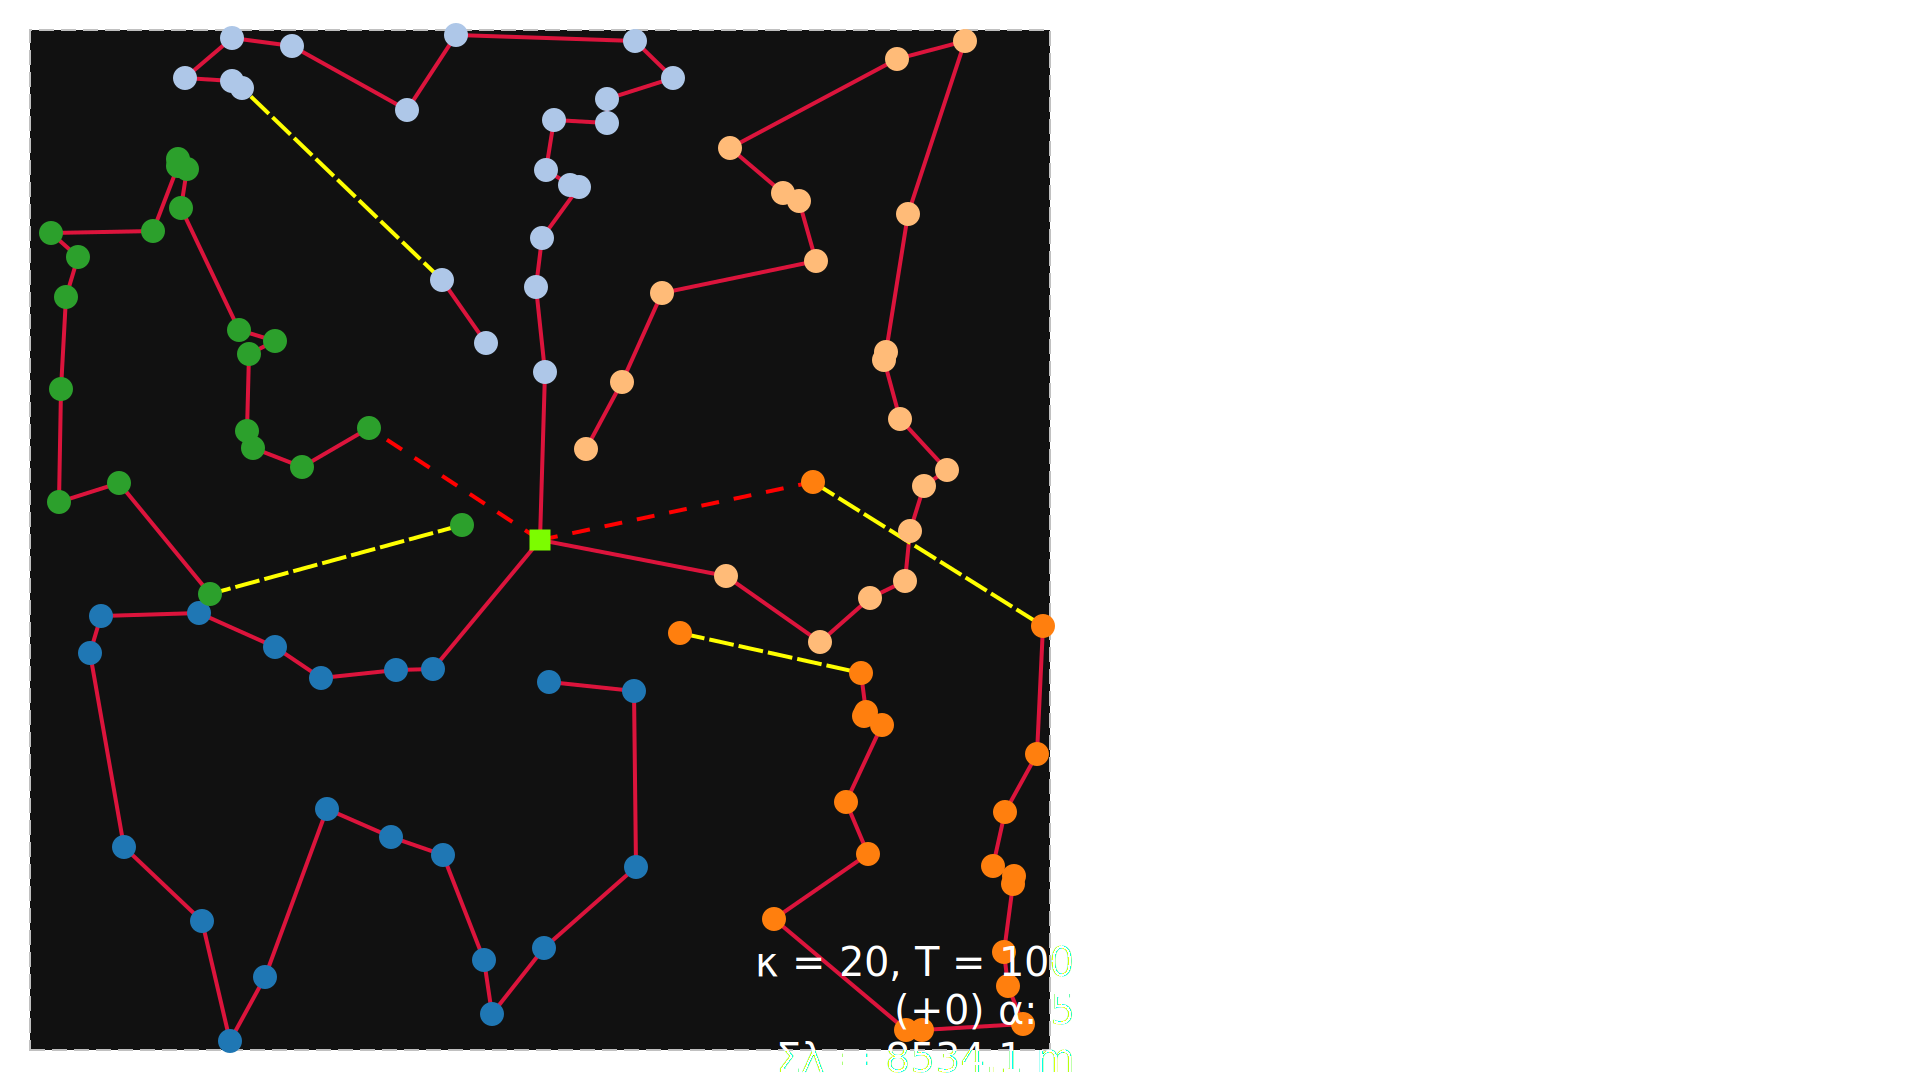

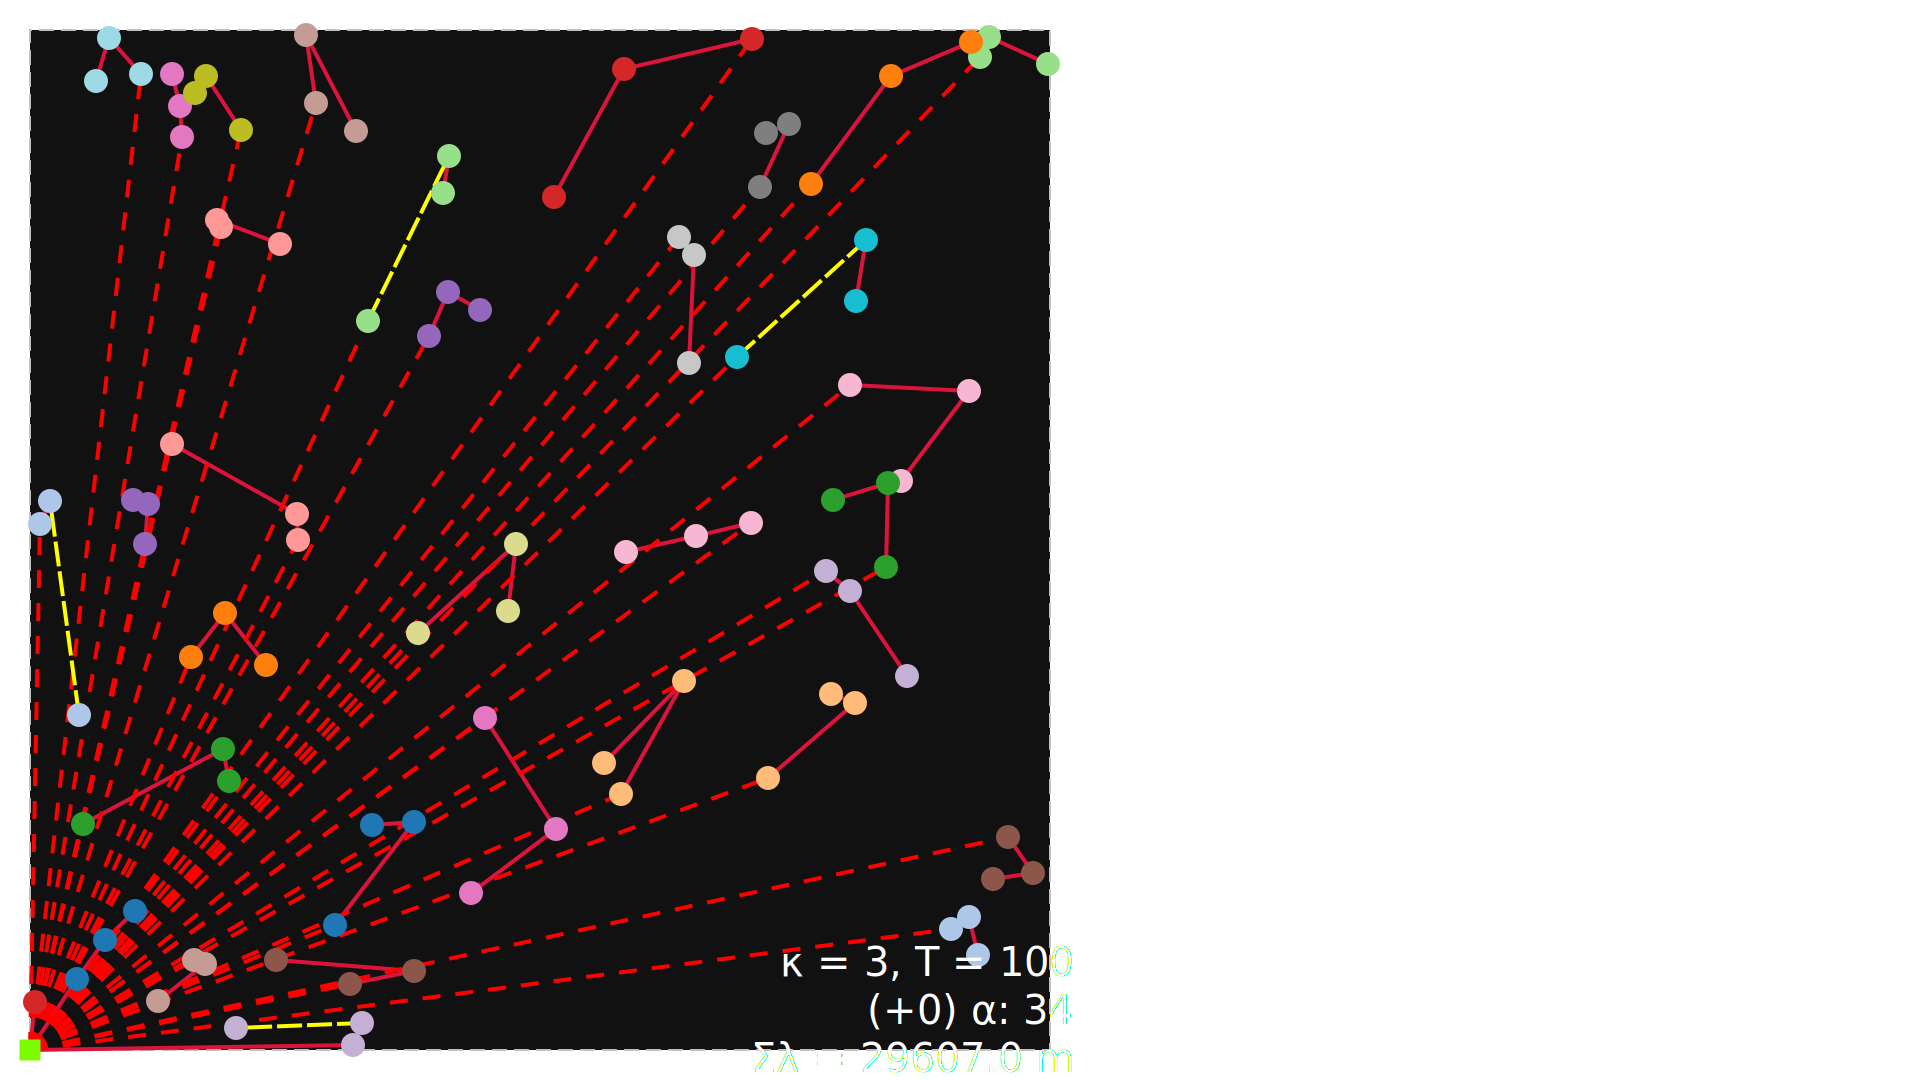

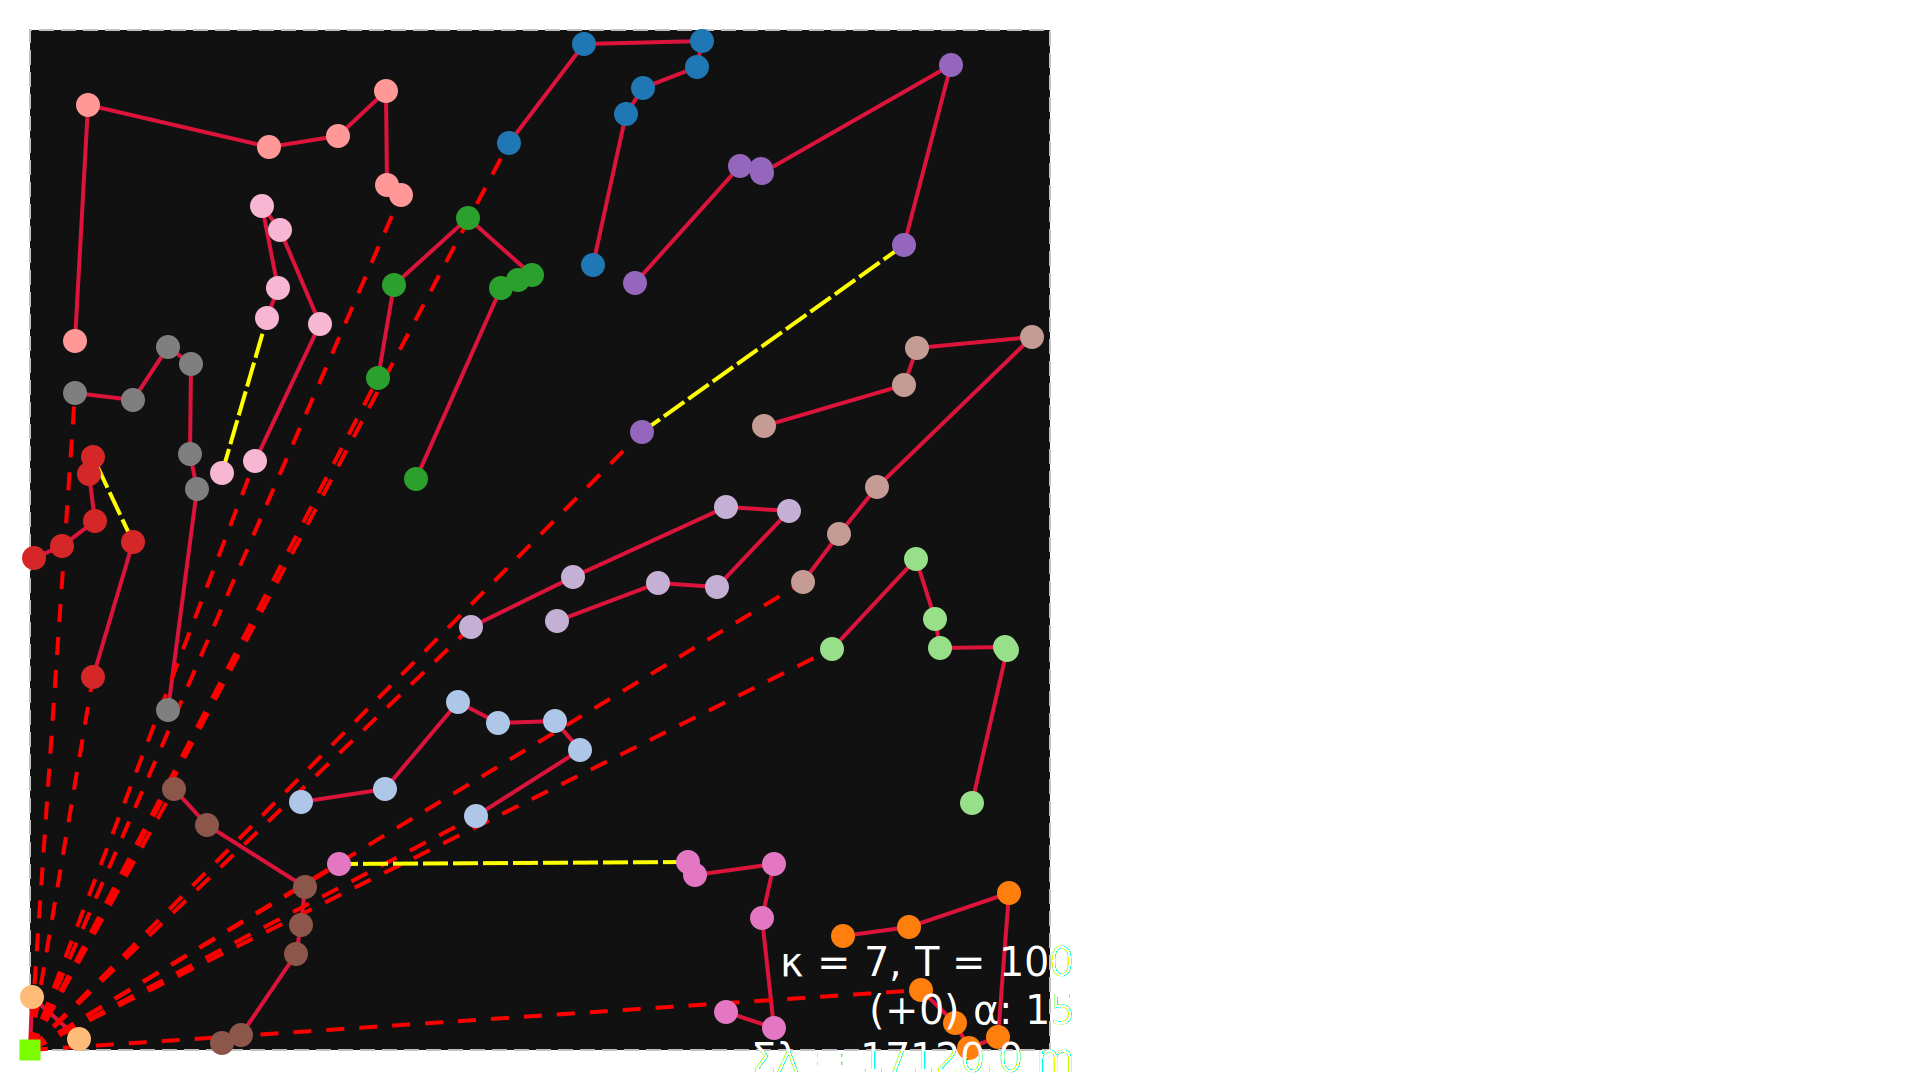

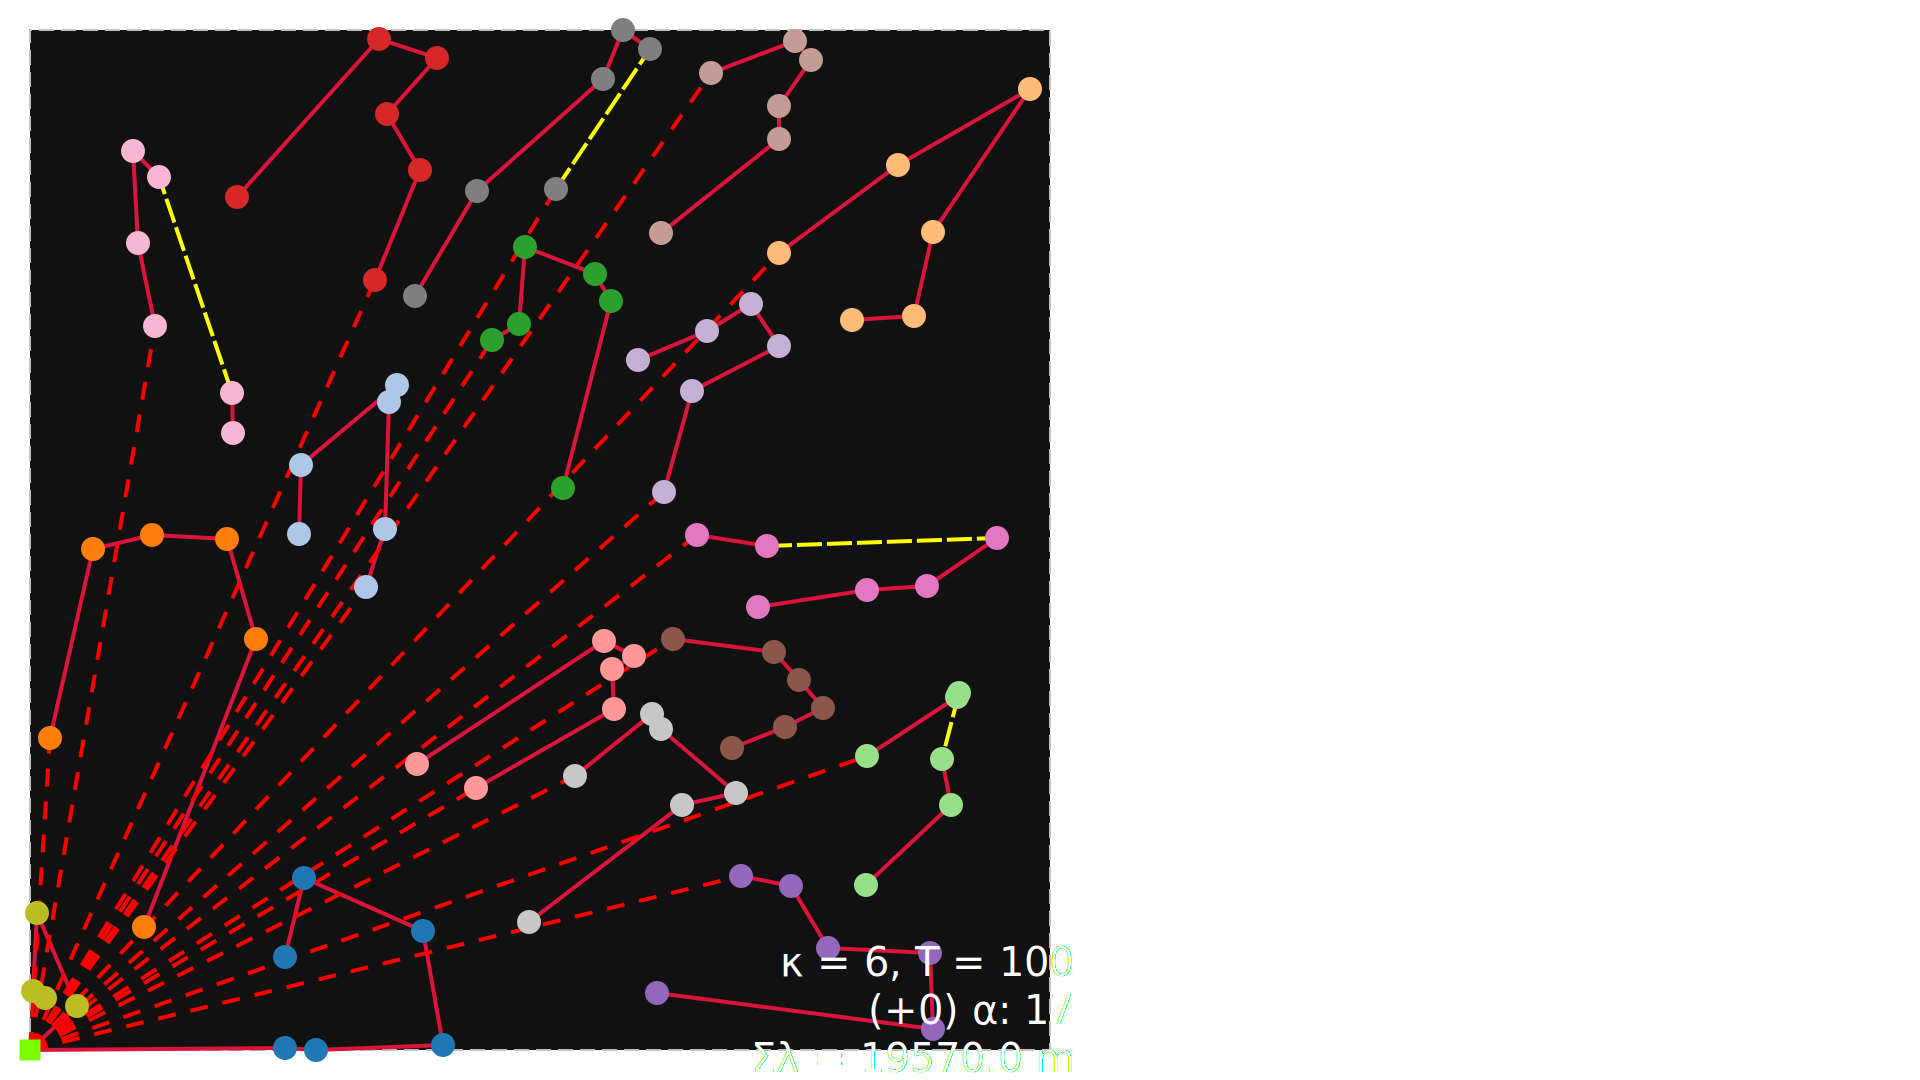

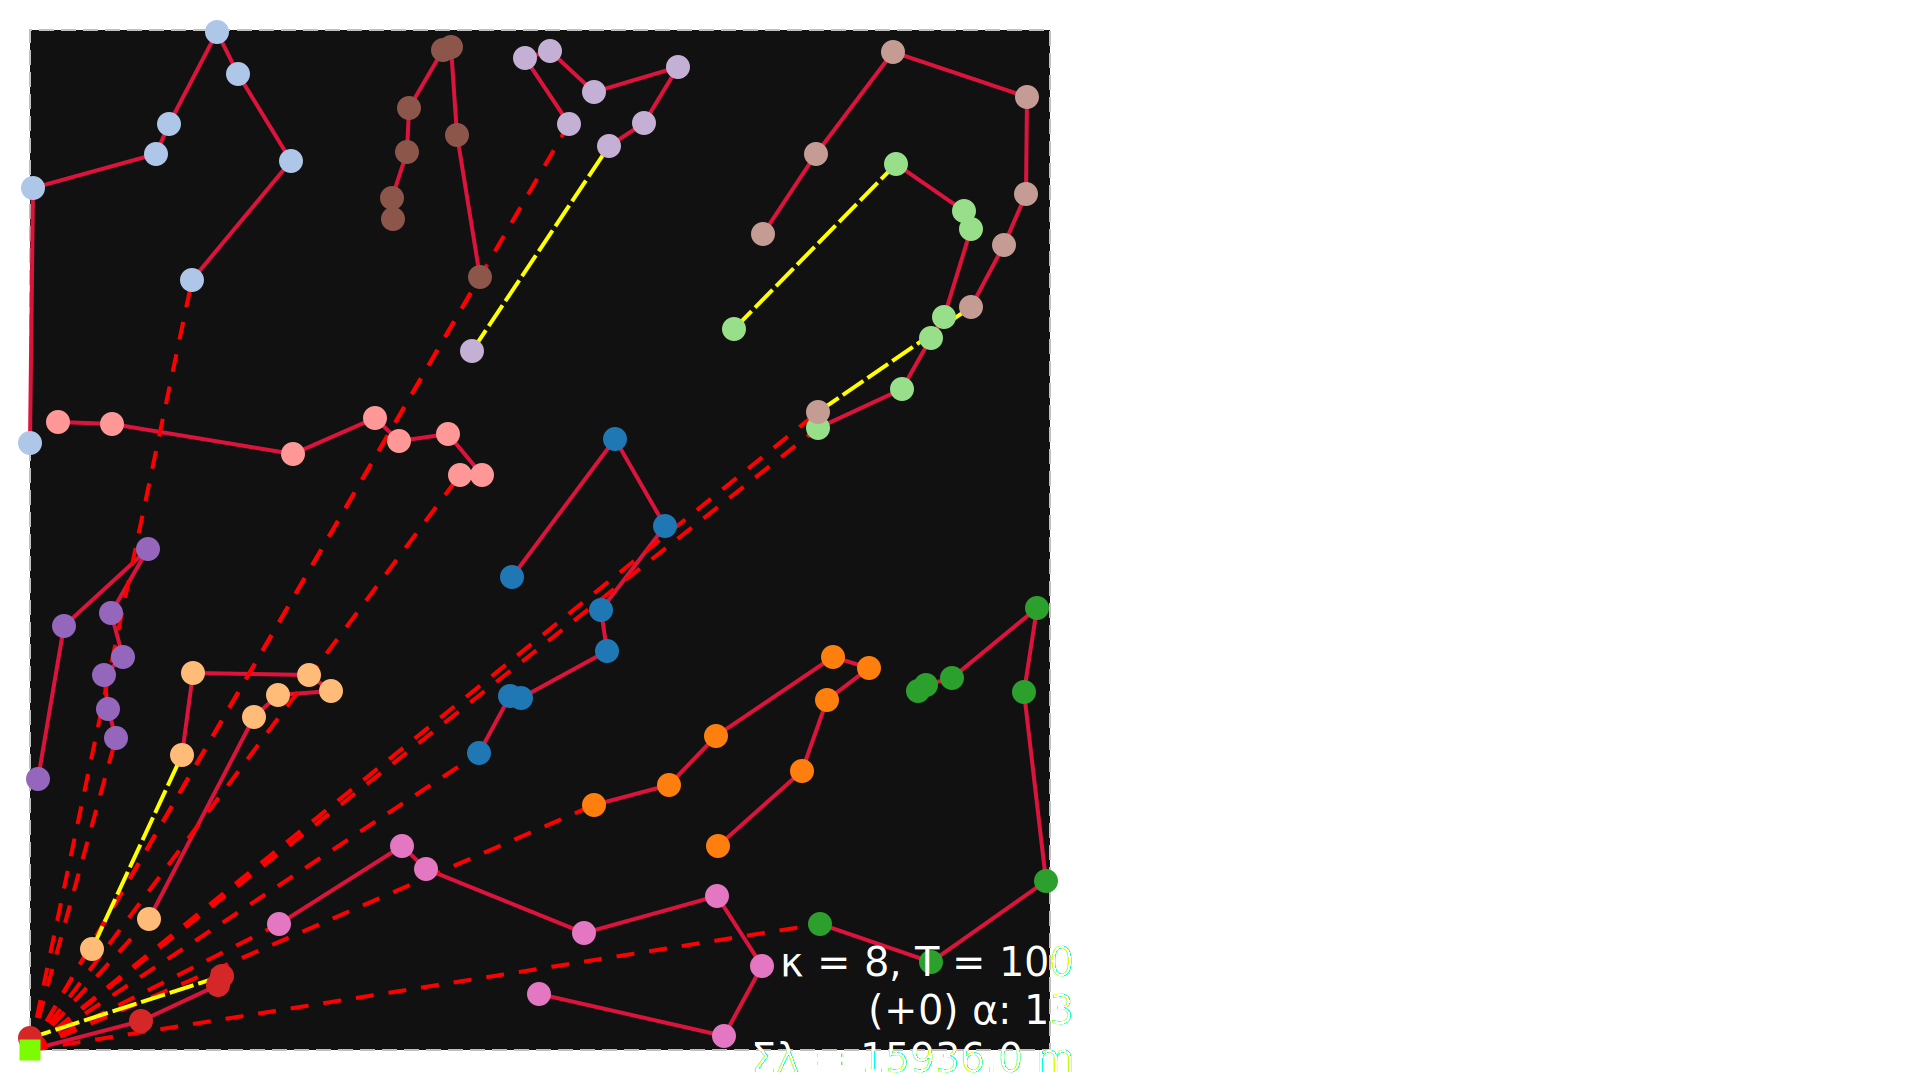

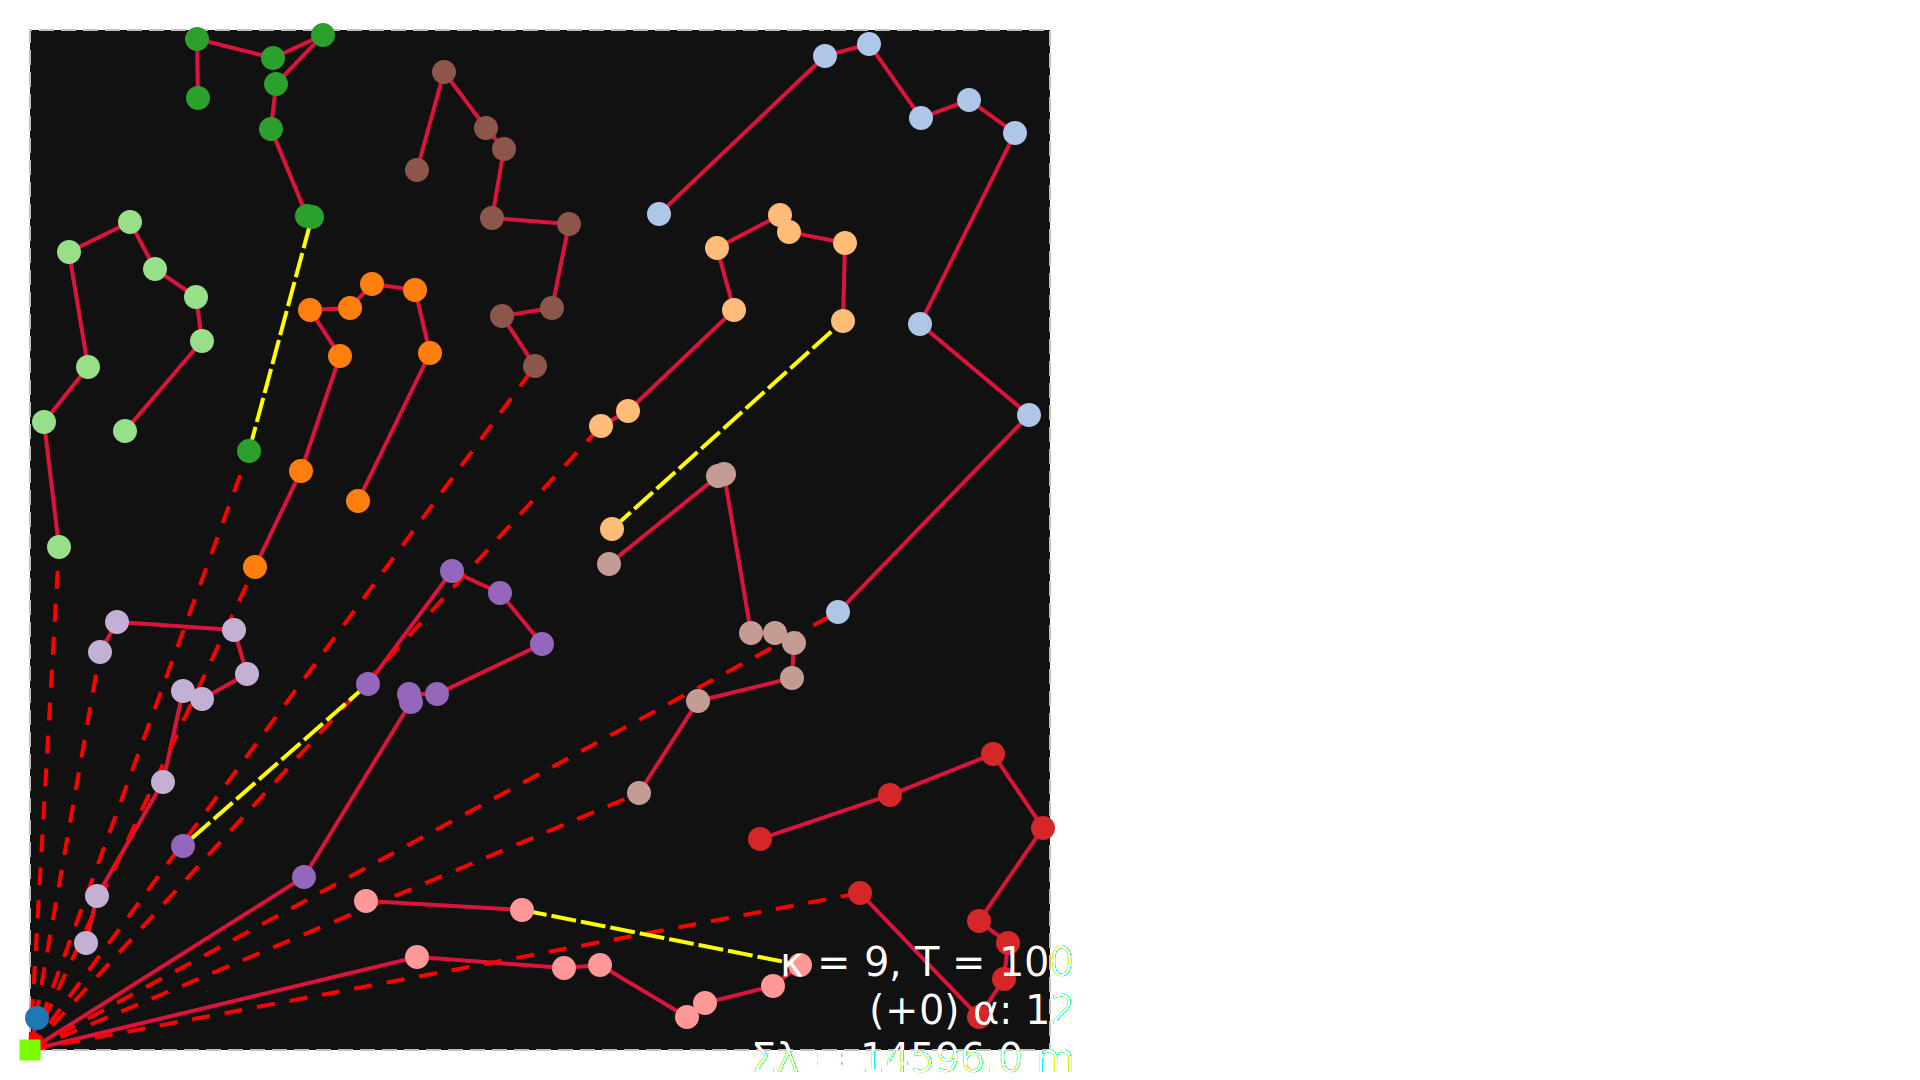

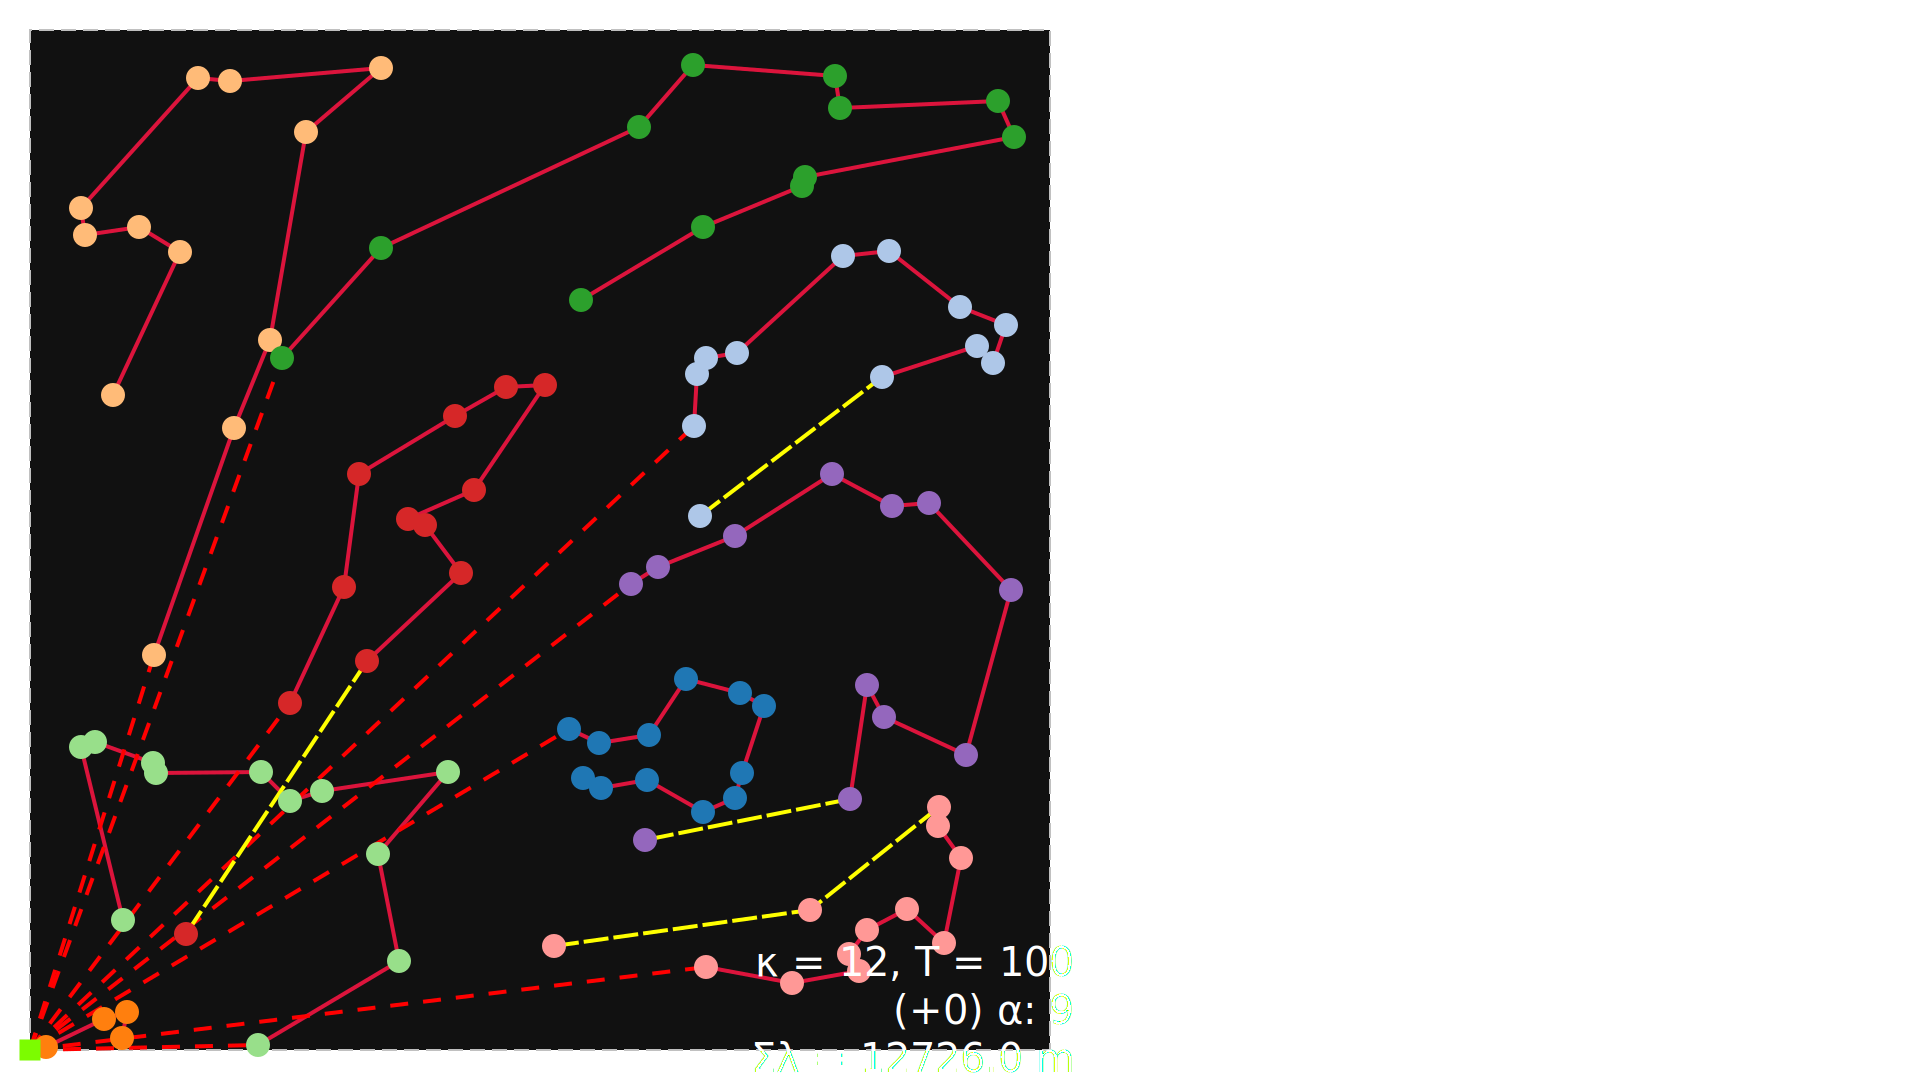

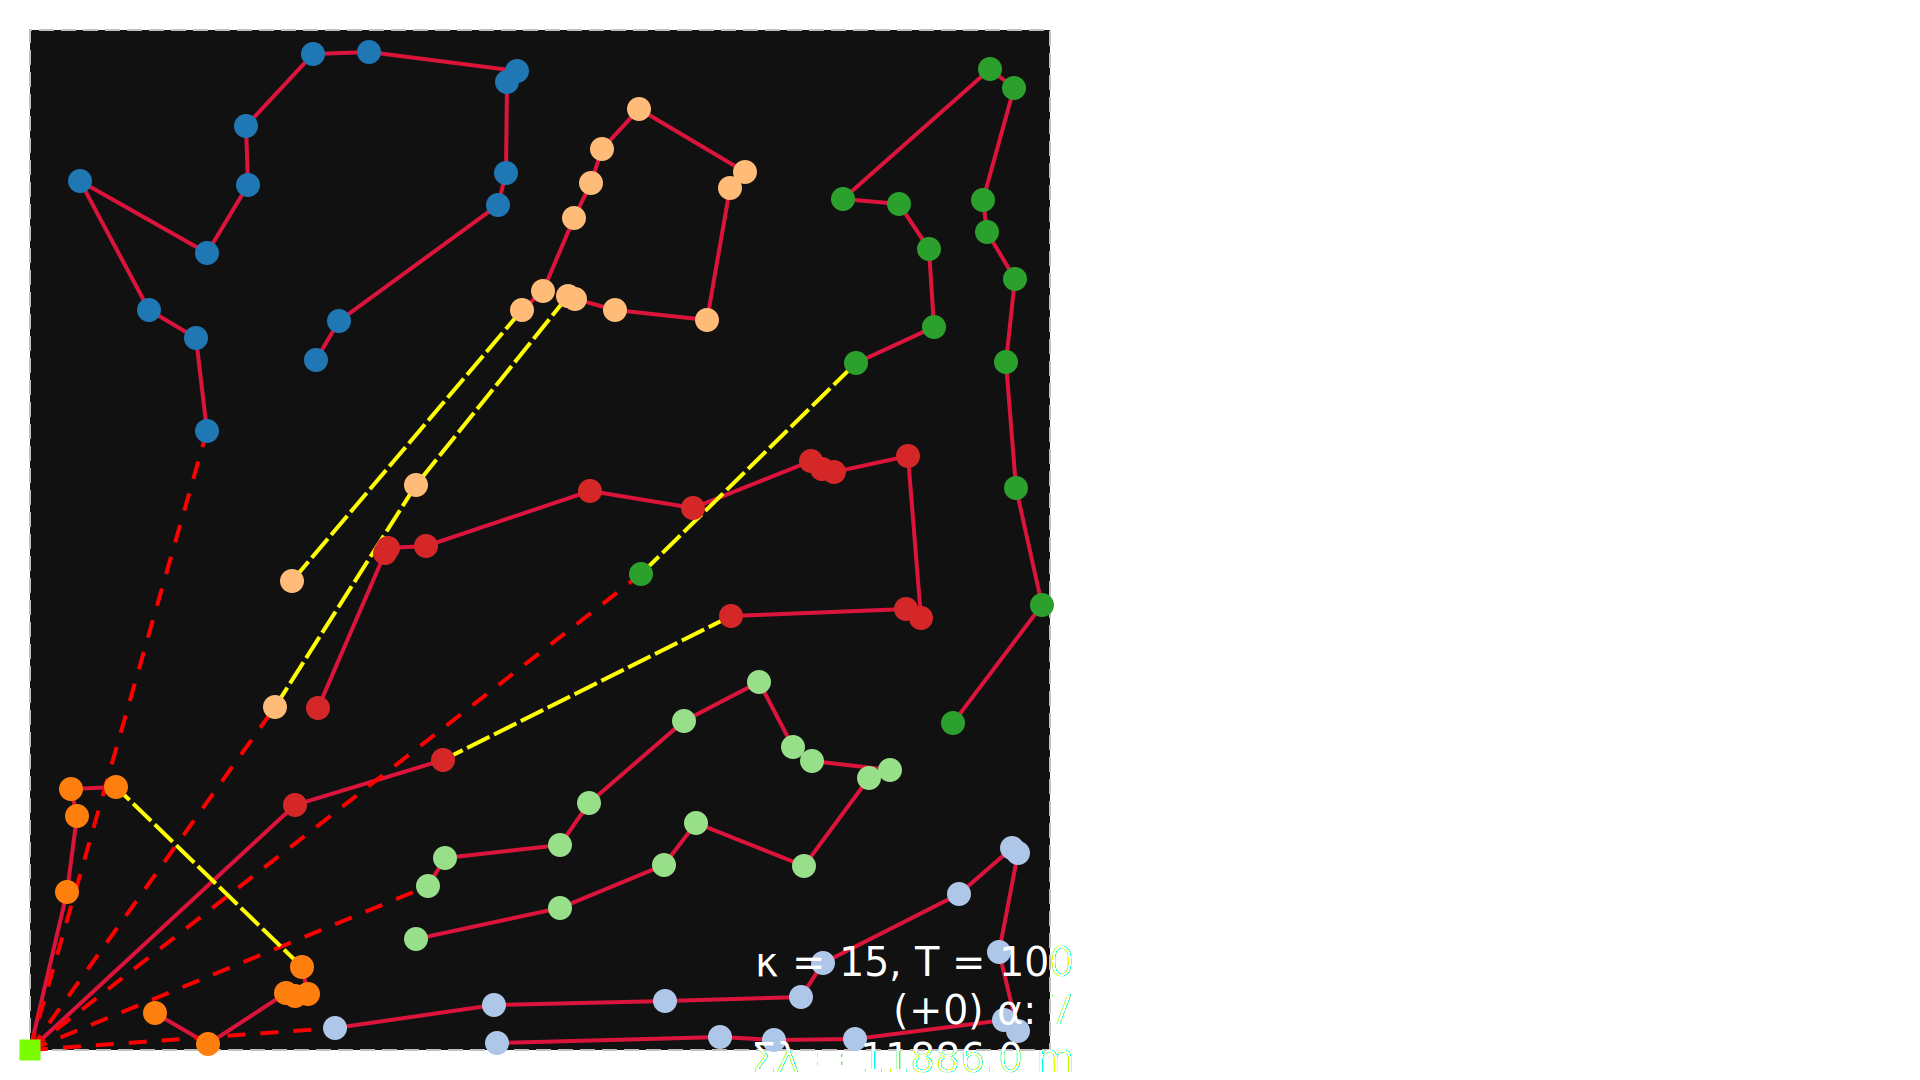

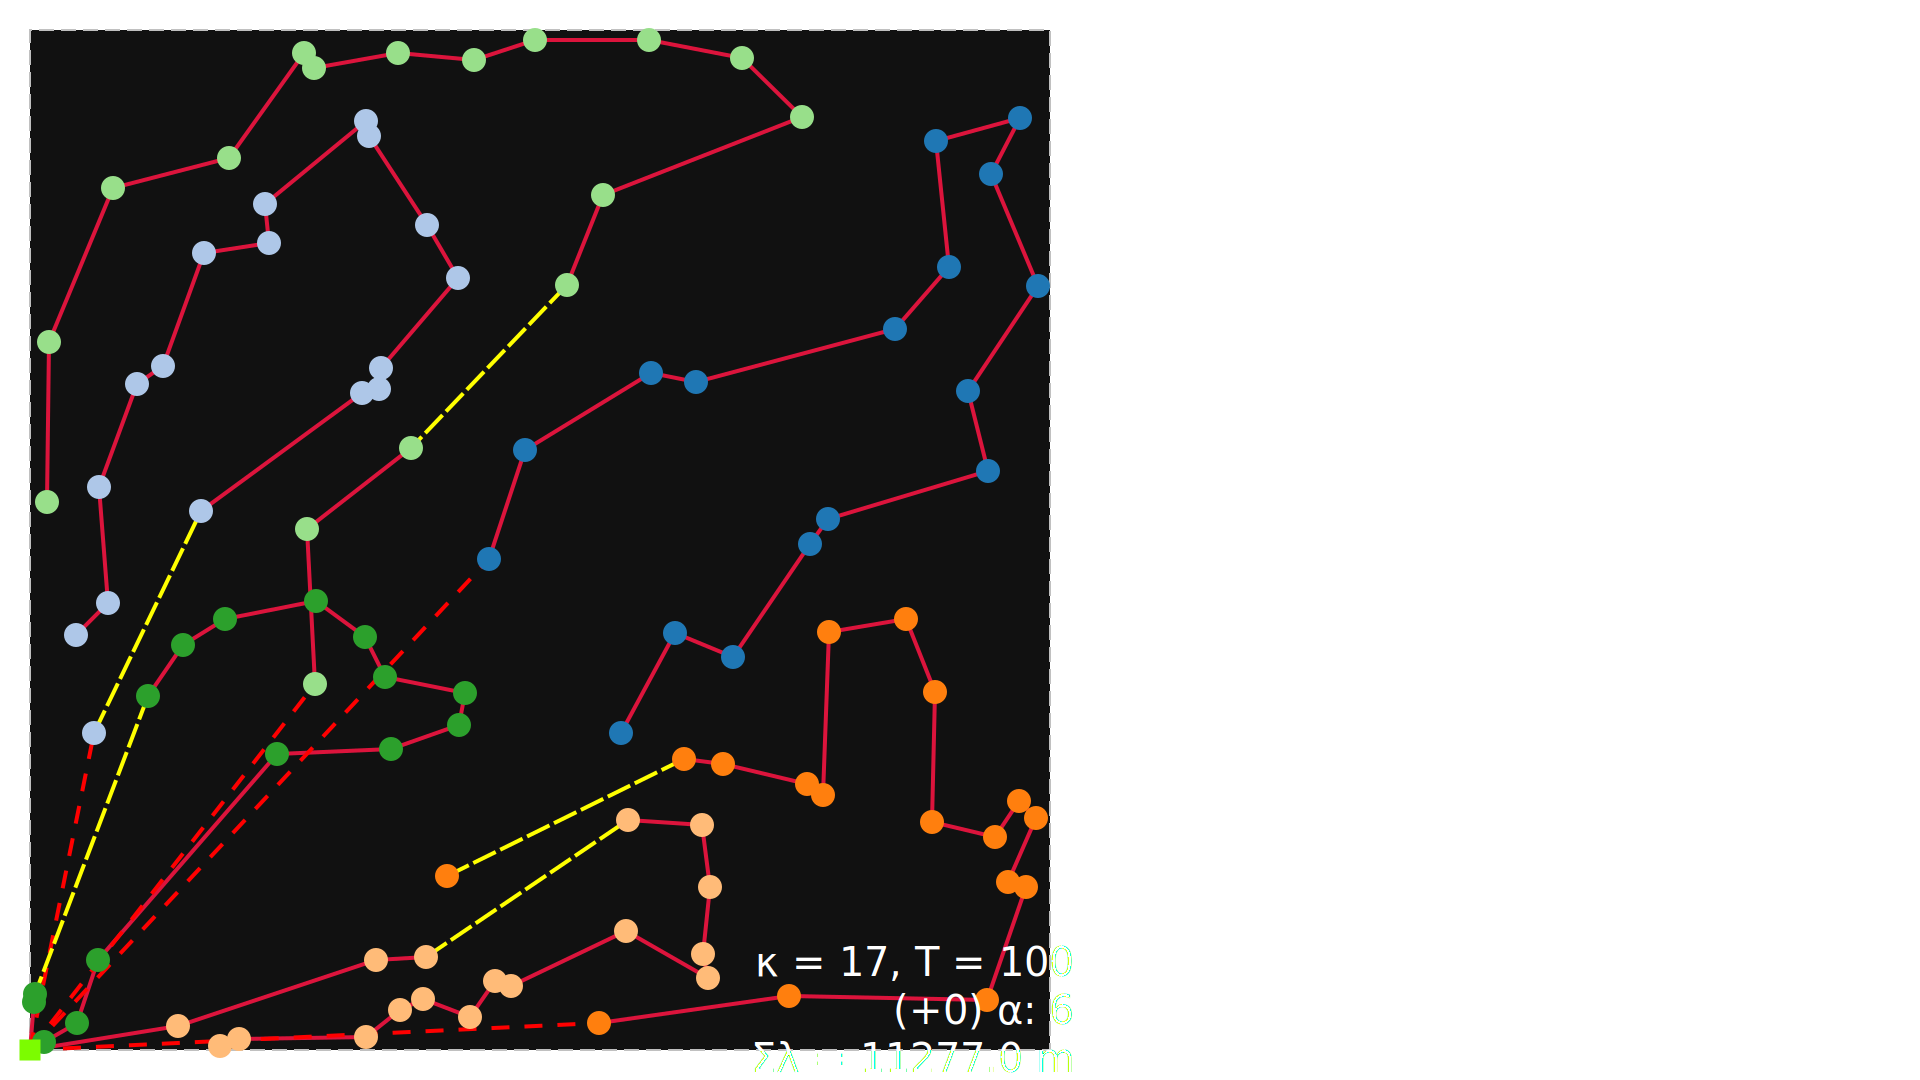

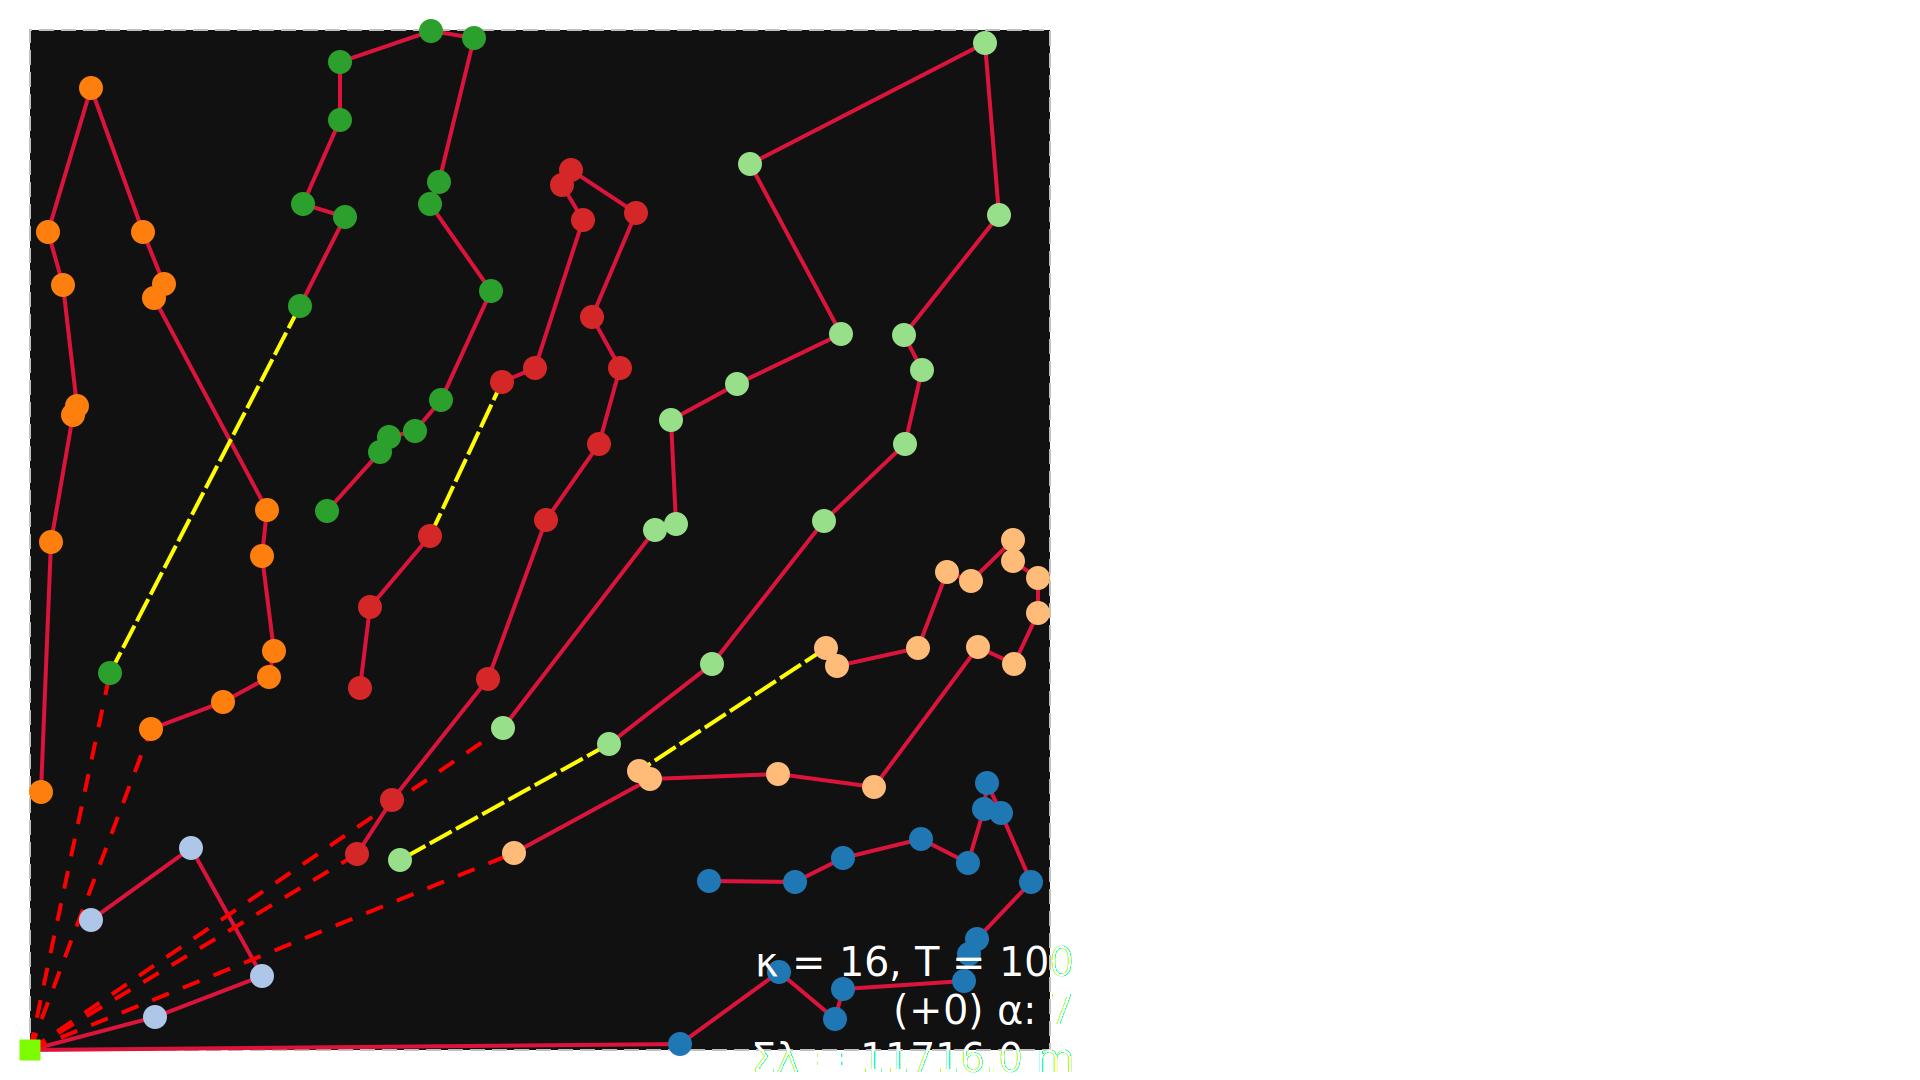

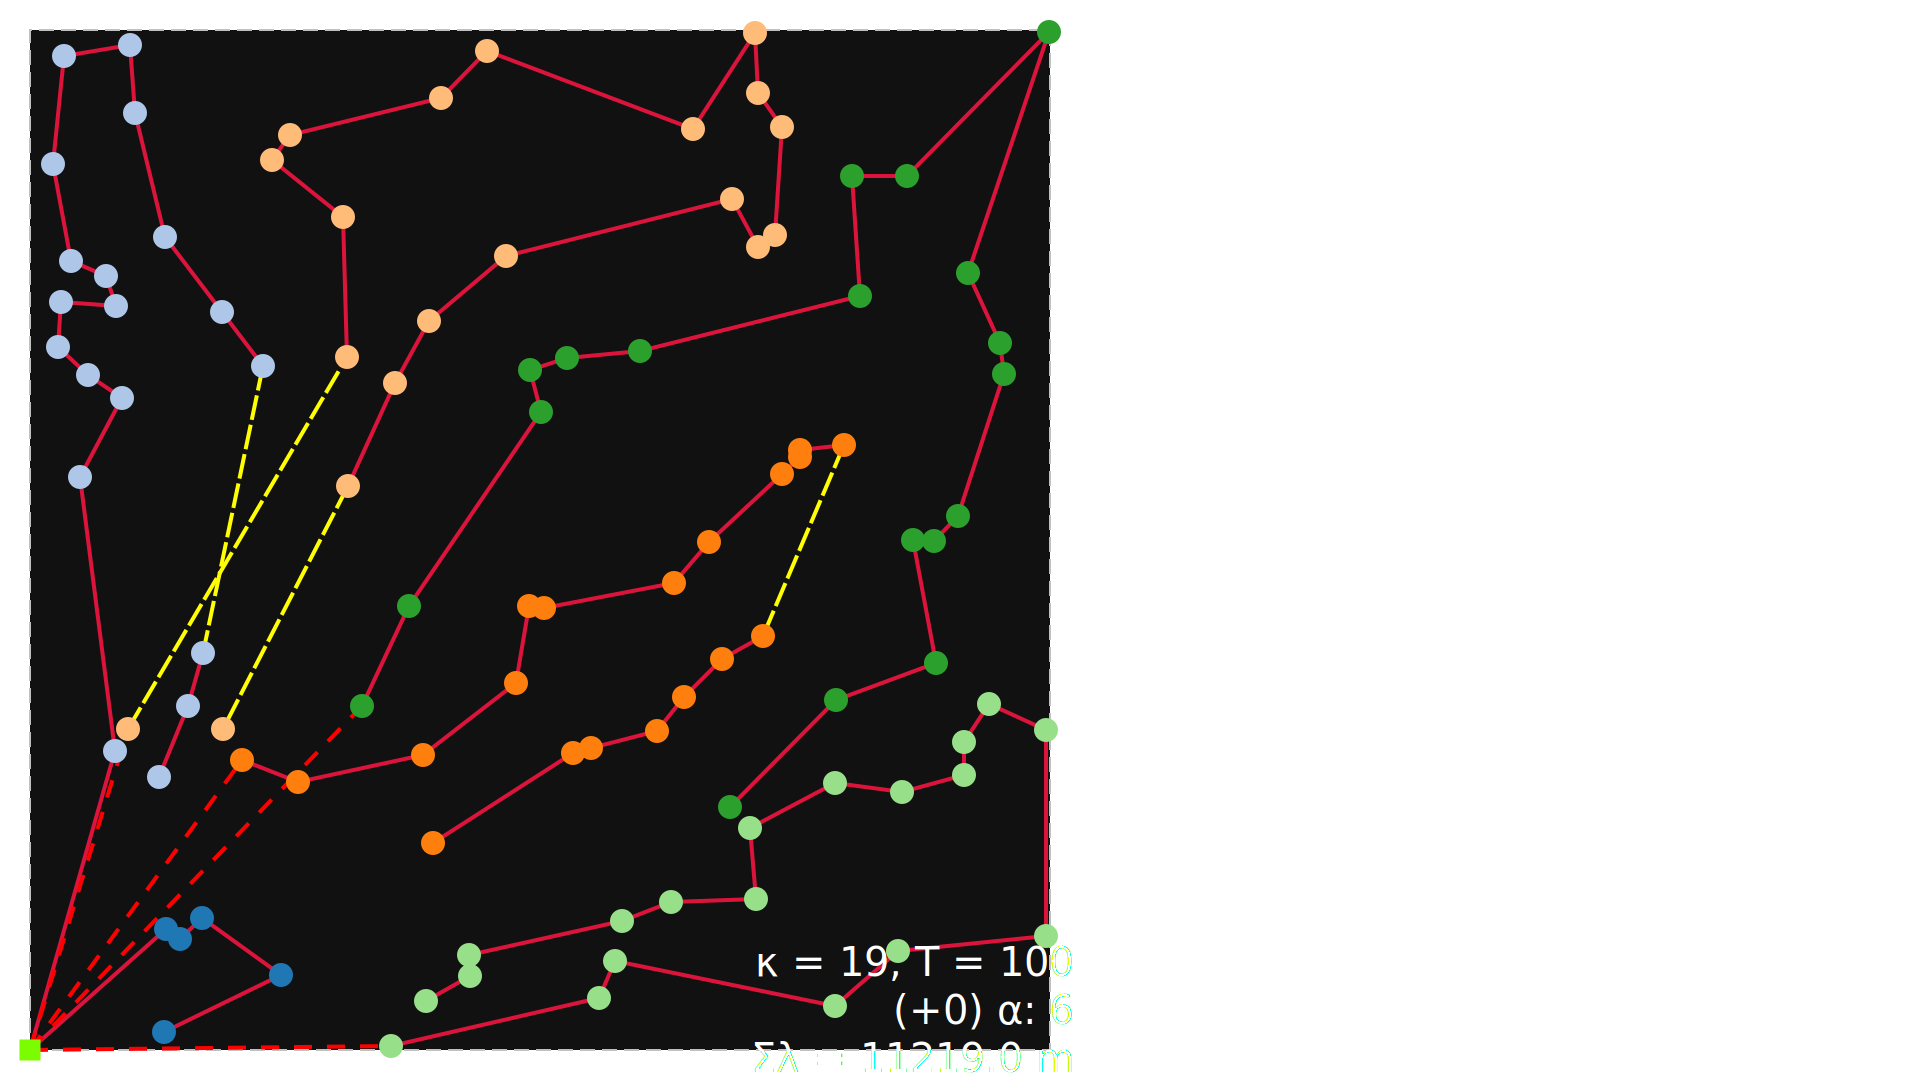

In [28]:
for name, rogues, svg in problems:
    if len(rogues) >= 4:
        display(svg)